# DATASET OVERVIEW

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy import stats
import pickle
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Data Loading and Basic Information
print("=== HDB Resale Price Data Analysis ===")
print("\n1. Data Loading and Basic Information")

# Load data
data_path = '../Dataset/'
df = pd.read_csv(data_path + 'train.csv')
print(f"Dataset shape: {df.shape}")
print(f"Dataset contains {df.shape[0]} records and {df.shape[1]} features")

# Display first few rows
print("\nFirst 5 rows of data:")
print(df.head())

# Basic data information
print("\nBasic data information:")
print(df.info())

# Descriptive statistics
print("\nDescriptive statistics for numerical features:")
print(df.describe())

# Check missing values
print("\nMissing values analysis:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0])


=== HDB Resale Price Data Analysis ===

1. Data Loading and Basic Information
Dataset shape: (162691, 11)
Dataset contains 162691 records and 11 features

First 5 rows of data:
     MONTH           TOWN FLAT_TYPE BLOCK              STREET FLOOR_RANGE  \
0  2020-10      woodlands    4 room  681B  woodlands drive 62    07 to 09   
1  2021-07         bishan    4 room   264    bishan street 24    07 to 09   
2  2021-05  bukit panjang    4 room   520       jelapang road    19 to 21   
3  2021-08        punggol    4 room  121B     edgedale plains    16 to 18   
4  2023-05        hougang    5 room  997B   Buangkok Crescent    10 to 12   

   FLOOR_AREA_SQM         FLAT_MODEL   ECO_CATEGORY  LEASE_COMMENCE_DATA  \
0           102.0  premium apartment  uncategorized                 2000   
1           104.0            model a  uncategorized                 1992   
2           102.0            model a  uncategorized                 1998   
3            93.0            model a  uncategorized     

# EDA

## 2.1 data distribution

NOTICE!!!log can turn to normal distribution, need to transform back when do inference



=== 2. Exploratory Data Analysis (EDA) ===


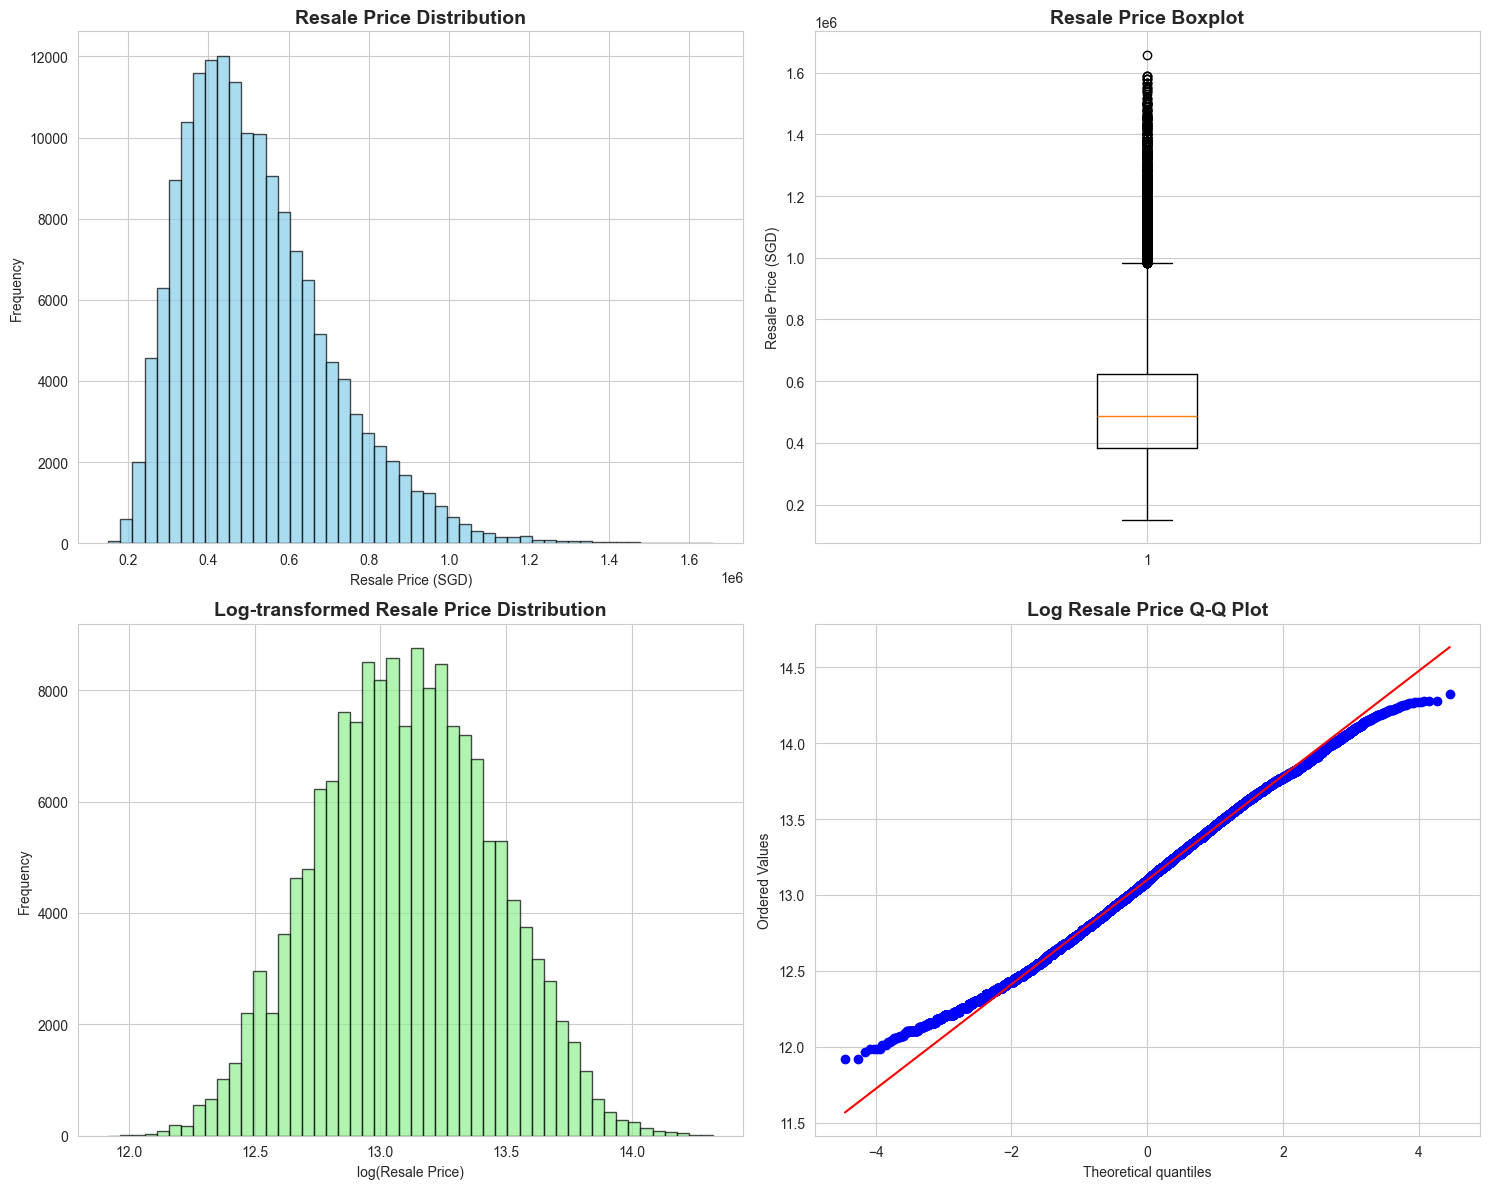


Resale Price Statistics:
Mean price: $518,843.00
Median price: $488,000.00
Minimum price: $150,000.00
Maximum price: $1,658,888.00
Standard deviation: $183,244.25

Log-transformed Resale Price Statistics:
Mean log price: 13.0999
Median log price: 13.0981
Minimum log price: 11.9184
Maximum log price: 14.3217
Standard deviation: 0.3447


In [2]:
# 2. Exploratory Data Analysis (EDA) - Targeting Resale Price
print("\n\n=== 2. Exploratory Data Analysis (EDA) ===")

# Apply log transformation to resale price
df['LOG_RESALE_PRICE'] = np.log(df['RESALE_PRICE'])

# 2.1 Resale Price Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Resale price histogram
axes[0,0].hist(df['RESALE_PRICE'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Resale Price Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Resale Price (SGD)')
axes[0,0].set_ylabel('Frequency')

# Resale price boxplot
axes[0,1].boxplot(df['RESALE_PRICE'])
axes[0,1].set_title('Resale Price Boxplot', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Resale Price (SGD)')

# Log-transformed price distribution
axes[1,0].hist(df['LOG_RESALE_PRICE'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Log-transformed Resale Price Distribution', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('log(Resale Price)')
axes[1,0].set_ylabel('Frequency')

# Q-Q plot for normality test
from scipy import stats
stats.probplot(df['LOG_RESALE_PRICE'], dist="norm", plot=axes[1,1])
axes[1,1].set_title('Log Resale Price Q-Q Plot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Basic price statistics
print(f"\nResale Price Statistics:")
print(f"Mean price: ${df['RESALE_PRICE'].mean():,.2f}")
print(f"Median price: ${df['RESALE_PRICE'].median():,.2f}")
print(f"Minimum price: ${df['RESALE_PRICE'].min():,.2f}")
print(f"Maximum price: ${df['RESALE_PRICE'].max():,.2f}")
print(f"Standard deviation: ${df['RESALE_PRICE'].std():,.2f}")

print(f"\nLog-transformed Resale Price Statistics:")
print(f"Mean log price: {df['LOG_RESALE_PRICE'].mean():.4f}")
print(f"Median log price: {df['LOG_RESALE_PRICE'].median():.4f}")
print(f"Minimum log price: {df['LOG_RESALE_PRICE'].min():.4f}")
print(f"Maximum log price: {df['LOG_RESALE_PRICE'].max():.4f}")
print(f"Standard deviation: {df['LOG_RESALE_PRICE'].std():.4f}")


Analysis of Price Distribution 
- The resale price distribution shows a right-skewed pattern with most properties concentrated in the $300K-$600K range.
- The presence of outliers above $1M suggests premium properties in prime locations or larger units."
- The log transformation reveals a more normal distribution, indicating that log-transformation might be beneficial for modeling.
- The Q-Q plot confirms the non-normal distribution of raw prices, supporting the need for transformation in predictive modeling.

##  2.2 Price Analysis by Different Features


2.2 Price Analysis by Different Features
clean flat type
before: ['4 room' '5 room' '3 room' '5-room' '3-room' 'executive' '4-room'
 '2-room' '2 room' '1 room' 'multi generation' '1-room']
after: ['4-room' '5-room' '3-room' 'executive' '2-room' '1-room'
 'multi generation']


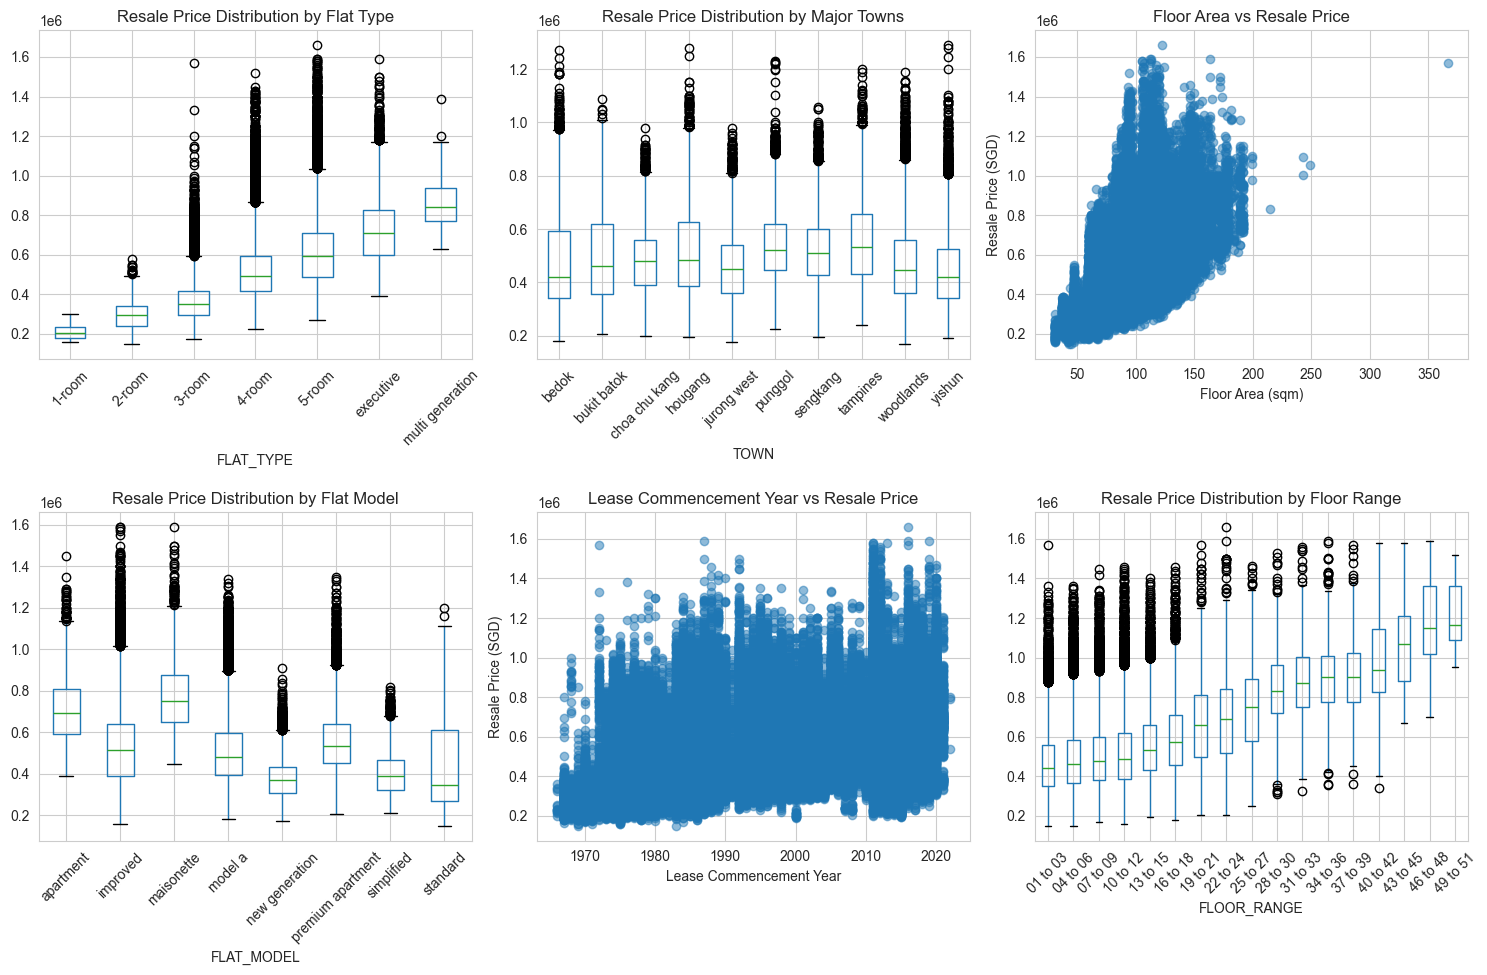

In [3]:
# 2.2 Price Analysis by Different Features
print("\n2.2 Price Analysis by Different Features")

# Analysis by flat type
# Data cleaning for flat type - standardize "x room" and "x-room" formats
print("clean flat type")
print(f"before: {df['FLAT_TYPE'].unique()}")

# Standardize flat type naming - convert "x room" to "x-room" format
df['FLAT_TYPE'] = df['FLAT_TYPE'].str.replace(' room', '-room', case=False)
df['FLAT_TYPE'] = df['FLAT_TYPE'].str.replace(' ROOM', '-ROOM', case=False)

print(f"after: {df['FLAT_TYPE'].unique()}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df.boxplot(column='RESALE_PRICE', by='FLAT_TYPE', ax=plt.gca())
plt.title('Resale Price Distribution by Flat Type')
plt.suptitle('')
plt.xticks(rotation=45)

# Analysis by town (top 10 towns)
plt.subplot(2, 3, 2)
top_towns = df['TOWN'].value_counts().head(10).index
df_top_towns = df[df['TOWN'].isin(top_towns)]
df_top_towns.boxplot(column='RESALE_PRICE', by='TOWN', ax=plt.gca())
plt.title('Resale Price Distribution by Major Towns')
plt.suptitle('')
plt.xticks(rotation=45)

# Analysis by floor area
plt.subplot(2, 3, 3)
plt.scatter(df['FLOOR_AREA_SQM'], df['RESALE_PRICE'], alpha=0.5)
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')
plt.title('Floor Area vs Resale Price')

# Analysis by flat model
plt.subplot(2, 3, 4)
top_models = df['FLAT_MODEL'].value_counts().head(8).index
df_top_models = df[df['FLAT_MODEL'].isin(top_models)]
df_top_models.boxplot(column='RESALE_PRICE', by='FLAT_MODEL', ax=plt.gca())
plt.title('Resale Price Distribution by Flat Model')
plt.suptitle('')
plt.xticks(rotation=45)

# Analysis by lease commencement year
plt.subplot(2, 3, 5)
plt.scatter(df['LEASE_COMMENCE_DATA'], df['RESALE_PRICE'], alpha=0.5)
plt.xlabel('Lease Commencement Year')
plt.ylabel('Resale Price (SGD)')
plt.title('Lease Commencement Year vs Resale Price')

# Analysis by floor range
plt.subplot(2, 3, 6)
df.boxplot(column='RESALE_PRICE', by='FLOOR_RANGE', ax=plt.gca())
plt.title('Resale Price Distribution by Floor Range')
plt.suptitle('')
plt.xticks(rotation=45)
plt.savefig('Resale Price Distribution by Floor Range.png')
plt.tight_layout()
plt.show()



Analysis of Price by Features ---
- Flat Type: cleaned  --> need encode 
- Location: quite average  --> use enternal method to evaluate correlation 
- Floor Area: Strong positive correlation between floor area and price, as expected for larger living spaces.
- Flat Model: apartment & maisonette shows premium price. --> need encode 
- Building Age: Newer buildings (higher lease commencement years) generally command higher prices, though location matters more.  --> convert to new feature Remaing age (> 99 - now + commence = remeaing years)
- Floor Level: Higher floors tend to have slightly higher prices, likely due to better views and less noise. ---> need to normalize floor level, as different build have diff max level 


2.4 Time Trend Analysis


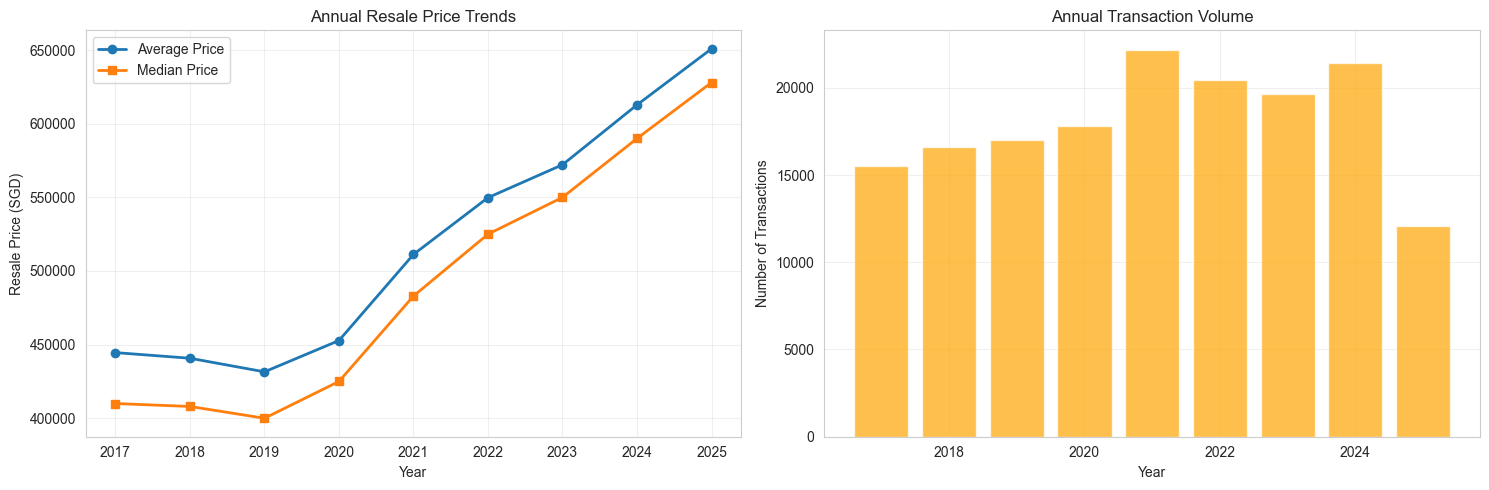


--- Analysis of Time Trends ---
Price trends show significant appreciation over the years, with both mean and median prices rising consistently.
The gap between mean and median prices indicates the presence of high-value outliers affecting the average.
Transaction volumes vary by year, with some years showing higher market activity than others.
The upward price trend reflects Singapore's robust property market and inflation effects over time.
Future projections (2024-2025) in the dataset suggest continued price appreciation, though these should be validated.


In [4]:
# 2.3 Time Trend Analysis
print("\n2.4 Time Trend Analysis")
df['YEAR'] = df['MONTH'].str[:4].astype(int)
df['MONTH_NUM'] = df['MONTH'].str[5:].astype(int)

# Annual price trend analysis
yearly_price = df.groupby('YEAR')['RESALE_PRICE'].agg(['mean', 'median', 'count']).reset_index()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(yearly_price['YEAR'], yearly_price['mean'], marker='o', linewidth=2, label='Average Price')
plt.plot(yearly_price['YEAR'], yearly_price['median'], marker='s', linewidth=2, label='Median Price')
plt.xlabel('Year')
plt.ylabel('Resale Price (SGD)')
plt.title('Annual Resale Price Trends')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(yearly_price['YEAR'], yearly_price['count'], alpha=0.7, color='orange')
plt.xlabel('Year')
plt.ylabel('Number of Transactions')
plt.title('Annual Transaction Volume')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n--- Analysis of Time Trends ---")
print("Price trends show significant appreciation over the years, with both mean and median prices rising consistently.")
print("The gap between mean and median prices indicates the presence of high-value outliers affecting the average.")
print("Transaction volumes vary by year, with some years showing higher market activity than others.")
print("The upward price trend reflects Singapore's robust property market and inflation effects over time.")
print("Future projections (2024-2025) in the dataset suggest continued price appreciation, though these should be validated.")



=== 3. Data Preprocessing and Feature Engineering ===
3.1 Missing Values Handling
No missing values detected in the dataset - no imputation required.

3.2 Feature Engineering
New features created:
- TRANSACTION_YEAR, TRANSACTION_MONTH: Extracted from MONTH
- REMAINING_AGE: Age of building at time of sale
- FLOOR_LEVEL_LOW, FLOOR_LEVEL_HIGH, FLOOR_LEVEL_MID: Floor level information
- PRICE_PER_SQM: Price per square meter
- Standardized categorical features

3.3 Categorical Variables Encoding
generated 21 one-hot encoded FLAT_MODEL columns and 26 one-hot encoded TOWN columns
column names: ['FLAT_MODEL_2 room', 'FLAT_MODEL_3gen', 'FLAT_MODEL_adjoined flat', 'FLAT_MODEL_apartment', 'FLAT_MODEL_dbss', 'FLAT_MODEL_improved', 'FLAT_MODEL_improved maisonette', 'FLAT_MODEL_maisonette', 'FLAT_MODEL_model a', 'FLAT_MODEL_model a maisonette'] ['TOWN_ang mo kio', 'TOWN_bedok', 'TOWN_bishan', 'TOWN_bukit batok', 'TOWN_bukit merah', 'TOWN_bukit panjang', 'TOWN_bukit timah', 'TOWN_central area', 'TO

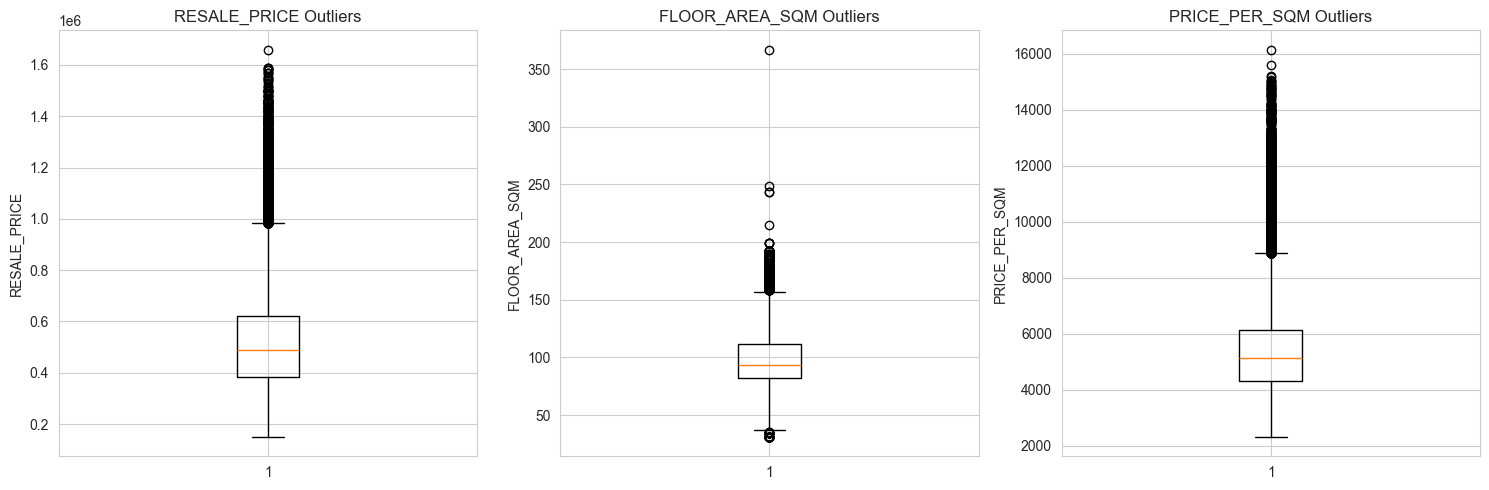


--- Analysis of Data Preprocessing and Feature Engineering ---
Feature Engineering: Successfully created meaningful derived features including remaining building age, floor levels, and price per sqm.
These new features provide additional insights and may improve model performance by capturing non-linear relationships.
Categorical Encoding: Applied appropriate encoding strategies - label encoding for ordinal data and one-hot encoding for nominal data.
The significant increase in dimensions after one-hot encoding suggests the need for dimensionality reduction techniques.
Feature Scaling: Both standard scaling and min-max normalization were applied to handle different scales across numerical features.
Outlier Detection: Identified outliers in key features, particularly in resale prices and price per sqm, which may represent luxury properties.
The preprocessing pipeline prepares the data effectively for machine learning algorithms while preserving important information.

Final processed d

In [5]:
# 3. Data Preprocessing and Feature Engineering
print("\n\n=== 3. Data Preprocessing and Feature Engineering ===")

# Create a copy for preprocessing
df_processed = df.copy()

# 3.1 Handle Missing Values (already confirmed no missing values)
print("3.1 Missing Values Handling")
print("No missing values detected in the dataset - no imputation required.")

# 3.2 Feature Engineering
print("\n3.2 Feature Engineering")

# Extract year and month from MONTH column
df_processed['TRANSACTION_YEAR'] = df_processed['MONTH'].str[:4].astype(int)
df_processed['TRANSACTION_MONTH'] = df_processed['MONTH'].str[5:].astype(int)

# Calculate releaning building age at time of sale
df_processed['REMAINING_AGE'] = 99 - df_processed['TRANSACTION_YEAR'] + df_processed['LEASE_COMMENCE_DATA']

# Extract floor level information
df_processed['FLOOR_LEVEL_LOW'] = df_processed['FLOOR_RANGE'].str.split(' to ').str[0].astype(int)
df_processed['FLOOR_LEVEL_HIGH'] = df_processed['FLOOR_RANGE'].str.split(' to ').str[1].astype(int)
df_processed['FLOOR_LEVEL_MID'] = (df_processed['FLOOR_LEVEL_LOW'] + df_processed['FLOOR_LEVEL_HIGH']) / 2 #use mid as floor level

# Create price per sqm feature
df_processed['PRICE_PER_SQM'] = df_processed['RESALE_PRICE'] / df_processed['FLOOR_AREA_SQM']

# Create categorical features for analysis
df_processed['FLAT_TYPE_CATEGORY'] = df_processed['FLAT_TYPE'].str.replace('-', ' ').str.title()
df_processed['TOWN_CATEGORY'] = df_processed['TOWN'].str.title()

print("New features created:")
print("- TRANSACTION_YEAR, TRANSACTION_MONTH: Extracted from MONTH")
print("- REMAINING_AGE: Age of building at time of sale")
print("- FLOOR_LEVEL_LOW, FLOOR_LEVEL_HIGH, FLOOR_LEVEL_MID: Floor level information")
print("- PRICE_PER_SQM: Price per square meter")
print("- Standardized categorical features")

# 3.3 Categorical Variables Encoding
print("\n3.3 Categorical Variables Encoding")

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import pandas as pd

# OrdinalEncoder was chosen for flat_type 
# because EDA (specifically the box plot) revealed a clear monotonic relationship 
# between the flat type categories and the resale price.
# As the flat type progresses (e.g., from '1-room' to '5-room' to 'executive'), 
# the median price consistently increases. 
# Encoding this feature ordinally preserves this important predictive relationship for the model.
flat_type_order = [
    '1-room', 
    '2-room', 
    '3-room', 
    '4-room', 
    '5-room',  
    'executive', 
    'multi generation'
]
flat_type_encoder=OrdinalEncoder(categories=[flat_type_order])
df_processed['FLAT_TYPE_ENCODED'] = flat_type_encoder.fit_transform(df_processed[['FLAT_TYPE']])

#Onehot encoding for FLAT_MODEL and TOWN
encoder=OneHotEncoder(sparse_output=False)
encoded_array=encoder.fit_transform(df_processed[['FLAT_MODEL']])
feature_names=encoder.get_feature_names_out()
encoded_df=pd.DataFrame(encoded_array,columns=feature_names,index=df_processed.index)

encoded_town_array=encoder.fit_transform(df_processed[['TOWN']])
town_feature_names=encoder.get_feature_names_out()
encoded_town_df=pd.DataFrame(encoded_town_array,columns=town_feature_names,index=df_processed.index)
df_processed=pd.concat([df_processed,encoded_df,encoded_town_df],axis=1)

print(f"generated {len(feature_names)} one-hot encoded FLAT_MODEL columns and {len(town_feature_names)} one-hot encoded TOWN columns")
print(f"column names: {list(feature_names)[:10]} {list(town_feature_names)[:10]}")

print(f"Dataset shape after encoding: {df_processed.shape}")
print(f"FLAT_TYPE and FLAT_MODEL,TOWN were all encoded")

# 3.4 Feature Scaling and Normalization
print("\n3.4 Feature Scaling and Normalization")

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select numerical features for scaling
numerical_features = ['FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'REMAINING_AGE', 
                     'FLOOR_LEVEL_MID', 'TRANSACTION_YEAR']

# Standard scaling
scaler_standard = StandardScaler()
df_processed[['FLOOR_AREA_SQM_SCALED', 'LEASE_COMMENCE_DATA_SCALED', 
              'REMAINING_AGE_SCALED', 'FLOOR_LEVEL_MID_SCALED', 
              'TRANSACTION_YEAR_SCALED']] = scaler_standard.fit_transform(df_processed[numerical_features])

# Min-Max scaling
scaler_minmax = MinMaxScaler()
df_processed[['FLOOR_AREA_SQM_NORM', 'LEASE_COMMENCE_DATA_NORM', 
              'REMAINING_AGE_NORM', 'FLOOR_LEVEL_MID_NORM', 
              'TRANSACTION_YEAR_NORM']] = scaler_minmax.fit_transform(df_processed[numerical_features])

print("Scaling completed for numerical features:")
print("- Standard scaling (mean=0, std=1)")
print("- Min-Max normalization (range 0-1)")

# 3.5 Outlier Detection and Treatment
print("\n3.5 Outlier Detection and Treatment")

# Detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for outliers in key features
outlier_features = ['RESALE_PRICE', 'FLOOR_AREA_SQM', 'PRICE_PER_SQM']
for feature in outlier_features:
    outliers, lower, upper = detect_outliers_iqr(df_processed, feature)
    print(f"{feature}: {len(outliers)} outliers detected (bounds: {lower:.2f} - {upper:.2f})")

# Visualize outliers
plt.figure(figsize=(15, 5))
for i, feature in enumerate(outlier_features):
    plt.subplot(1, 3, i+1)
    plt.boxplot(df_processed[feature])
    plt.title(f'{feature} Outliers')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

print("\n--- Analysis of Data Preprocessing and Feature Engineering ---")
print("Feature Engineering: Successfully created meaningful derived features including remaining building age, floor levels, and price per sqm.")
print("These new features provide additional insights and may improve model performance by capturing non-linear relationships.")
print("Categorical Encoding: Applied appropriate encoding strategies - label encoding for ordinal data and one-hot encoding for nominal data.")
print("The significant increase in dimensions after one-hot encoding suggests the need for dimensionality reduction techniques.")
print("Feature Scaling: Both standard scaling and min-max normalization were applied to handle different scales across numerical features.")
print("Outlier Detection: Identified outliers in key features, particularly in resale prices and price per sqm, which may represent luxury properties.")
print("The preprocessing pipeline prepares the data effectively for machine learning algorithms while preserving important information.")

# Display final processed dataset info
print(f"\nFinal processed dataset shape: {df_processed.shape}")
print("\nSample of processed features:")
print(df_processed[['RESALE_PRICE', 'REMAINING_AGE', 'FLOOR_LEVEL_MID', 'PRICE_PER_SQM']].head())




3.5.1 Numerical Features Correlation Analysis


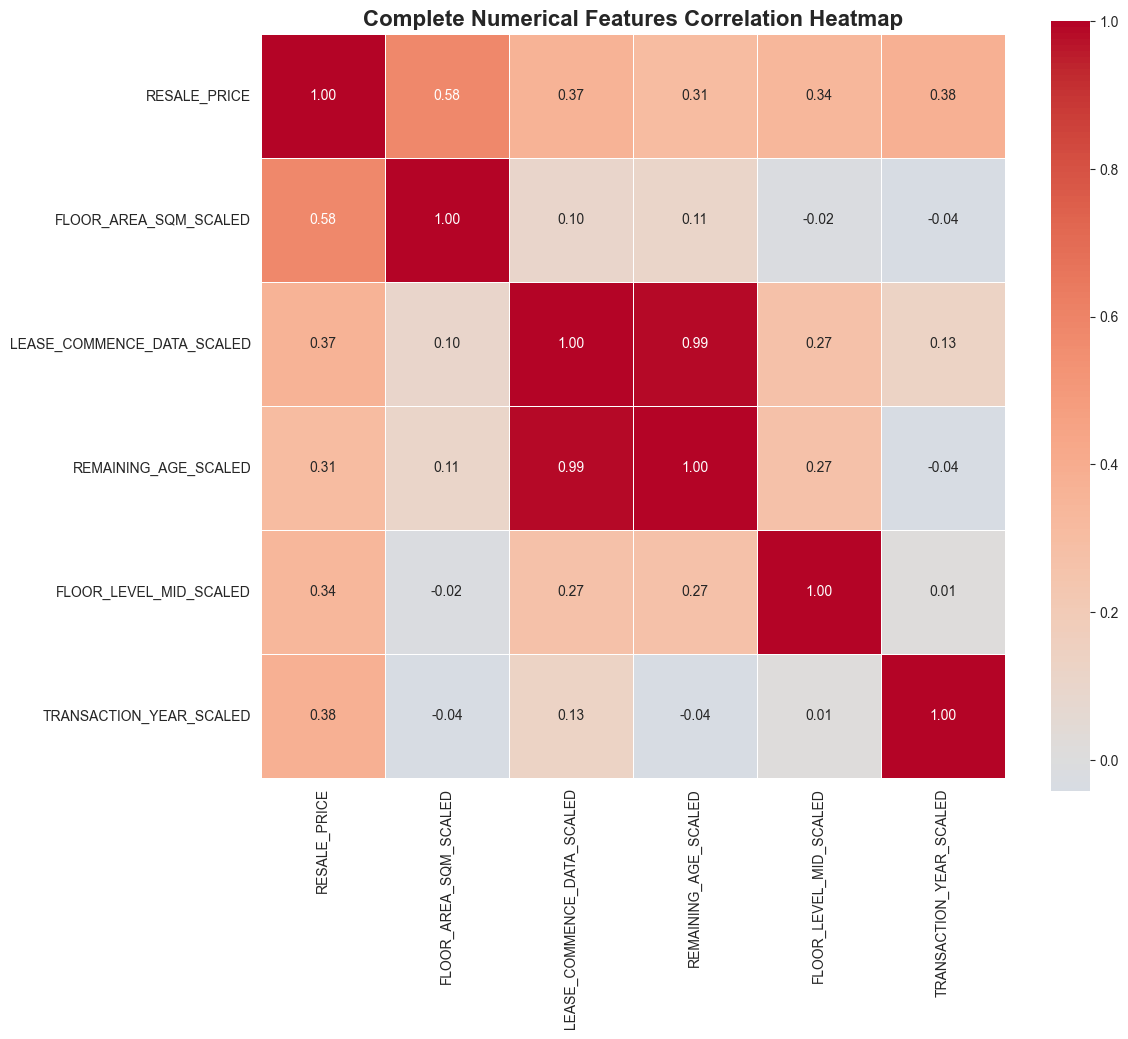

Correlation Matrix:
                            RESALE_PRICE  FLOOR_AREA_SQM_SCALED  \
RESALE_PRICE                    1.000000               0.578110   
FLOOR_AREA_SQM_SCALED           0.578110               1.000000   
LEASE_COMMENCE_DATA_SCALED      0.368591               0.099533   
REMAINING_AGE_SCALED            0.305490               0.107608   
FLOOR_LEVEL_MID_SCALED          0.341653              -0.015026   
TRANSACTION_YEAR_SCALED         0.382053              -0.042396   

                            LEASE_COMMENCE_DATA_SCALED  REMAINING_AGE_SCALED  \
RESALE_PRICE                                  0.368591              0.305490   
FLOOR_AREA_SQM_SCALED                         0.099533              0.107608   
LEASE_COMMENCE_DATA_SCALED                    1.000000              0.985258   
REMAINING_AGE_SCALED                          0.985258              1.000000   
FLOOR_LEVEL_MID_SCALED                        0.272163              0.272311   
TRANSACTION_YEAR_SCALED       

In [6]:
# 3.5.1 Correlation Analysis
print("\n3.5.1 Numerical Features Correlation Analysis")
numeric_cols = ['FLOOR_AREA_SQM_SCALED', 'LEASE_COMMENCE_DATA_SCALED', 
              'REMAINING_AGE_SCALED', 'FLOOR_LEVEL_MID_SCALED', 
              'TRANSACTION_YEAR_SCALED','RESALE_PRICE']

correlation_matrix = df_processed[numeric_cols].corr()

if 'RESALE_PRICE' in correlation_matrix.columns:
    cols_reordered = ['RESALE_PRICE'] + [col for col in correlation_matrix.columns if col != 'RESALE_PRICE']
    correlation_matrix = correlation_matrix.loc[cols_reordered, cols_reordered]

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Complete Numerical Features Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)

print("\n--- Analysis of Correlations ---")

In [7]:
print("\n=== 3.6 Duplication Check ===")
total_with_duplication=df_processed.duplicated(keep=False).sum()
duplicated_rows=df_processed.duplicated().sum()
print(f"total number of duplicated rows: {total_with_duplication}")
print(f"original rows after removing duplication: {total_with_duplication-duplicated_rows}")


=== 3.6 Duplication Check ===
total number of duplicated rows: 241
original rows after removing duplication: 120


In [8]:
df_processed=df_processed.drop_duplicates(keep='first')
print(f"final rows after removing duplication: {len(df_processed)}")

final rows after removing duplication: 162570


In [8]:
print("\n=== 3.7 String Standardization ===")
print(f"Before processing, the unique values of 'STREET' is: {df_processed['STREET'].nunique()}, the values are: {df_processed['STREET'].value_counts()}")
print(f"Before processing, the unique values of 'TOWN' is: {df_processed['TOWN'].nunique()}, the values are: {df_processed['TOWN'].value_counts()}")
print(f"Before processing, the unique values of 'BLOCK' is: {df_processed['BLOCK'].nunique()}, the values are: {df_processed['BLOCK'].value_counts()}")



=== 3.7 String Standardization ===
Before processing, the unique values of 'STREET' is: 1145, the values are: STREET
yishun ring road         1398
bedok reservoir road     1032
punggol drive            1020
punggol field             947
Yishun Ring Road          940
                         ... 
jurong west street 51       3
margaret drive              2
geylang east avenue 2       2
Margaret Drive              1
Seng Poh Road               1
Name: count, Length: 1145, dtype: int64
Before processing, the unique values of 'TOWN' is: 26, the values are: TOWN
sengkang           13335
punggol            11925
woodlands          11506
yishun             11175
tampines           11030
jurong west        10781
bedok               8457
hougang             8120
choa chu kang       7397
bukit batok         6733
ang mo kio          6623
bukit merah         6184
bukit panjang       5891
toa payoh           5182
kallang/whampoa     4994
sembawang           4828
pasir ris           4737
queenstown 

In [9]:
df_processed['STREET'] = df_processed['STREET'].str.strip().str.lower()
df_processed['TOWN'] = df_processed['TOWN'].str.strip().str.lower()
df_processed['BLOCK'] = df_processed['BLOCK'].str.strip().str.upper()
print(f"After processing, the unique values of 'STREET' is: {df_processed['STREET'].nunique()}, the values are: {df_processed['STREET'].value_counts()}")
print(f"After processing, the unique values of 'TOWN' is: {df_processed['TOWN'].nunique()}, the values are: {df_processed['TOWN'].value_counts()}")
print(f"After processing, the unique values of 'BLOCK' is: {df_processed['BLOCK'].nunique()}, the values are: {df_processed['BLOCK'].value_counts()}")

After processing, the unique values of 'STREET' is: 574, the values are: STREET
yishun ring road         2338
punggol drive            1713
bedok reservoir road     1691
punggol field            1559
ang mo kio avenue 10     1545
                         ... 
kreta ayer road             6
seng poh road               4
sembawang way               4
margaret drive              3
geylang east avenue 2       2
Name: count, Length: 574, dtype: int64
After processing, the unique values of 'TOWN' is: 26, the values are: TOWN
sengkang           13335
punggol            11925
woodlands          11506
yishun             11175
tampines           11030
jurong west        10781
bedok               8457
hougang             8120
choa chu kang       7397
bukit batok         6733
ang mo kio          6623
bukit merah         6184
bukit panjang       5891
toa payoh           5182
kallang/whampoa     4994
sembawang           4828
pasir ris           4737
queenstown          4391
geylang             3995
c

In [10]:
print("\n=== 3.8 Feature engineering with auxiliary features ===")
df_hawker=pd.read_csv(data_path+'auxiliary-data/sg-gov-hawkers.csv')
df_mrt=pd.read_csv(data_path+'auxiliary-data/sg-mrt-stations.csv')
df_primary=pd.read_csv(data_path+'auxiliary-data/sg-primary-schools.csv')
df_secondary=pd.read_csv(data_path+'auxiliary-data/sg-secondary-schools.csv')
df_malls=pd.read_csv(data_path+'auxiliary-data/sg-shopping-malls.csv')
df_hdb=pd.read_csv(data_path+'auxiliary-data/sg-hdb-block-details.csv')
print("load auxiliary data successfully")


=== 3.8 Feature engineering with auxiliary features ===
load auxiliary data successfully


In [11]:
important_cols=['BLOCK','ADDRESS','LATITUDE','LONGITUDE','POSTAL_CODE','MAX_FLOOR']
df_hdb_processed=df_hdb[important_cols]
df_hdb_processed['ADDRESS']=df_hdb_processed['ADDRESS'].str.strip().str.lower()
df_hdb_processed['BLOCK']=df_hdb_processed['BLOCK'].str.strip().str.upper()
df_hdb_processed.head()

,BLOCK,ADDRESS,LATITUDE,LONGITUDE,POSTAL_CODE,MAX_FLOOR
0,205,marsiling drive,1.444946,103.773484,730205,14
1,506,west coast drive,1.312517,103.760867,120506,12
2,267B,compassvale link,1.383200,103.897433,542267,17
3,521,woodlands drive 14,1.433716,103.793326,730521,12
4,531,pasir ris drive 1,1.371362,103.950398,510531,8


In [12]:
df_processed_with_location=df_processed.merge(df_hdb_processed,left_on=['BLOCK','STREET'],right_on=['BLOCK','ADDRESS'],how='left')
df_processed_with_location.head()
df_processed_with_location.shape

(162691, 86)

In [14]:
df_processed_with_location.drop(columns=['ADDRESS'],inplace=True)
df_processed_with_location.shape


(162570, 85)

In [13]:
df_processed_with_location['FLOOR_LEVEL_RATIO'] = (
    df_processed_with_location['FLOOR_LEVEL_MID'] / 
    df_processed_with_location['MAX_FLOOR']
)
df_processed_with_location['FLOOR_LEVEL_CATEGORY'] = pd.cut(
    df_processed_with_location['FLOOR_LEVEL_RATIO'],
    bins=[0, 0.33, 0.67, 1.0],
    labels=['Low', 'Mid', 'High']
)
df_processed_with_location[['TOWN','RESALE_PRICE','FLOOR_LEVEL_RATIO','FLOOR_LEVEL_MID','MAX_FLOOR']].head()


,TOWN,RESALE_PRICE,FLOOR_LEVEL_RATIO,FLOOR_LEVEL_MID,MAX_FLOOR
0,woodlands,420000.0,0.571429,8.0,14
1,bishan,585000.0,0.500000,8.0,16
2,bukit panjang,450000.0,1.000000,20.0,20
3,punggol,465000.0,1.000000,17.0,17
4,hougang,710000.0,0.687500,11.0,16



 ===floor level vs price analysis===

1. overall floor level vs price analysis

 correlation matrix:
                   FLOOR_LEVEL_RATIO  FLOOR_LEVEL_MID  RESALE_PRICE
FLOOR_LEVEL_RATIO           1.000000         0.701071      0.050091
FLOOR_LEVEL_MID             0.701071         1.000000      0.341653
RESALE_PRICE                0.050091         0.341653      1.000000

 Based on floor level, the price statistics are:
                      count       mean    median        std       min  \
FLOOR_LEVEL_CATEGORY                                                    
Low                   40223  504647.28  480000.0  171856.99  150000.0   
Mid                   65355  513677.72  480000.0  183203.75  150000.0   
High                  51670  539525.51  508000.0  190432.72  157000.0   

                            max  
FLOOR_LEVEL_CATEGORY             
Low                   1450000.0  
Mid                   1658888.0  
High                  1588000.0  

Mid Floor vs Low Floor premium: 0.00%



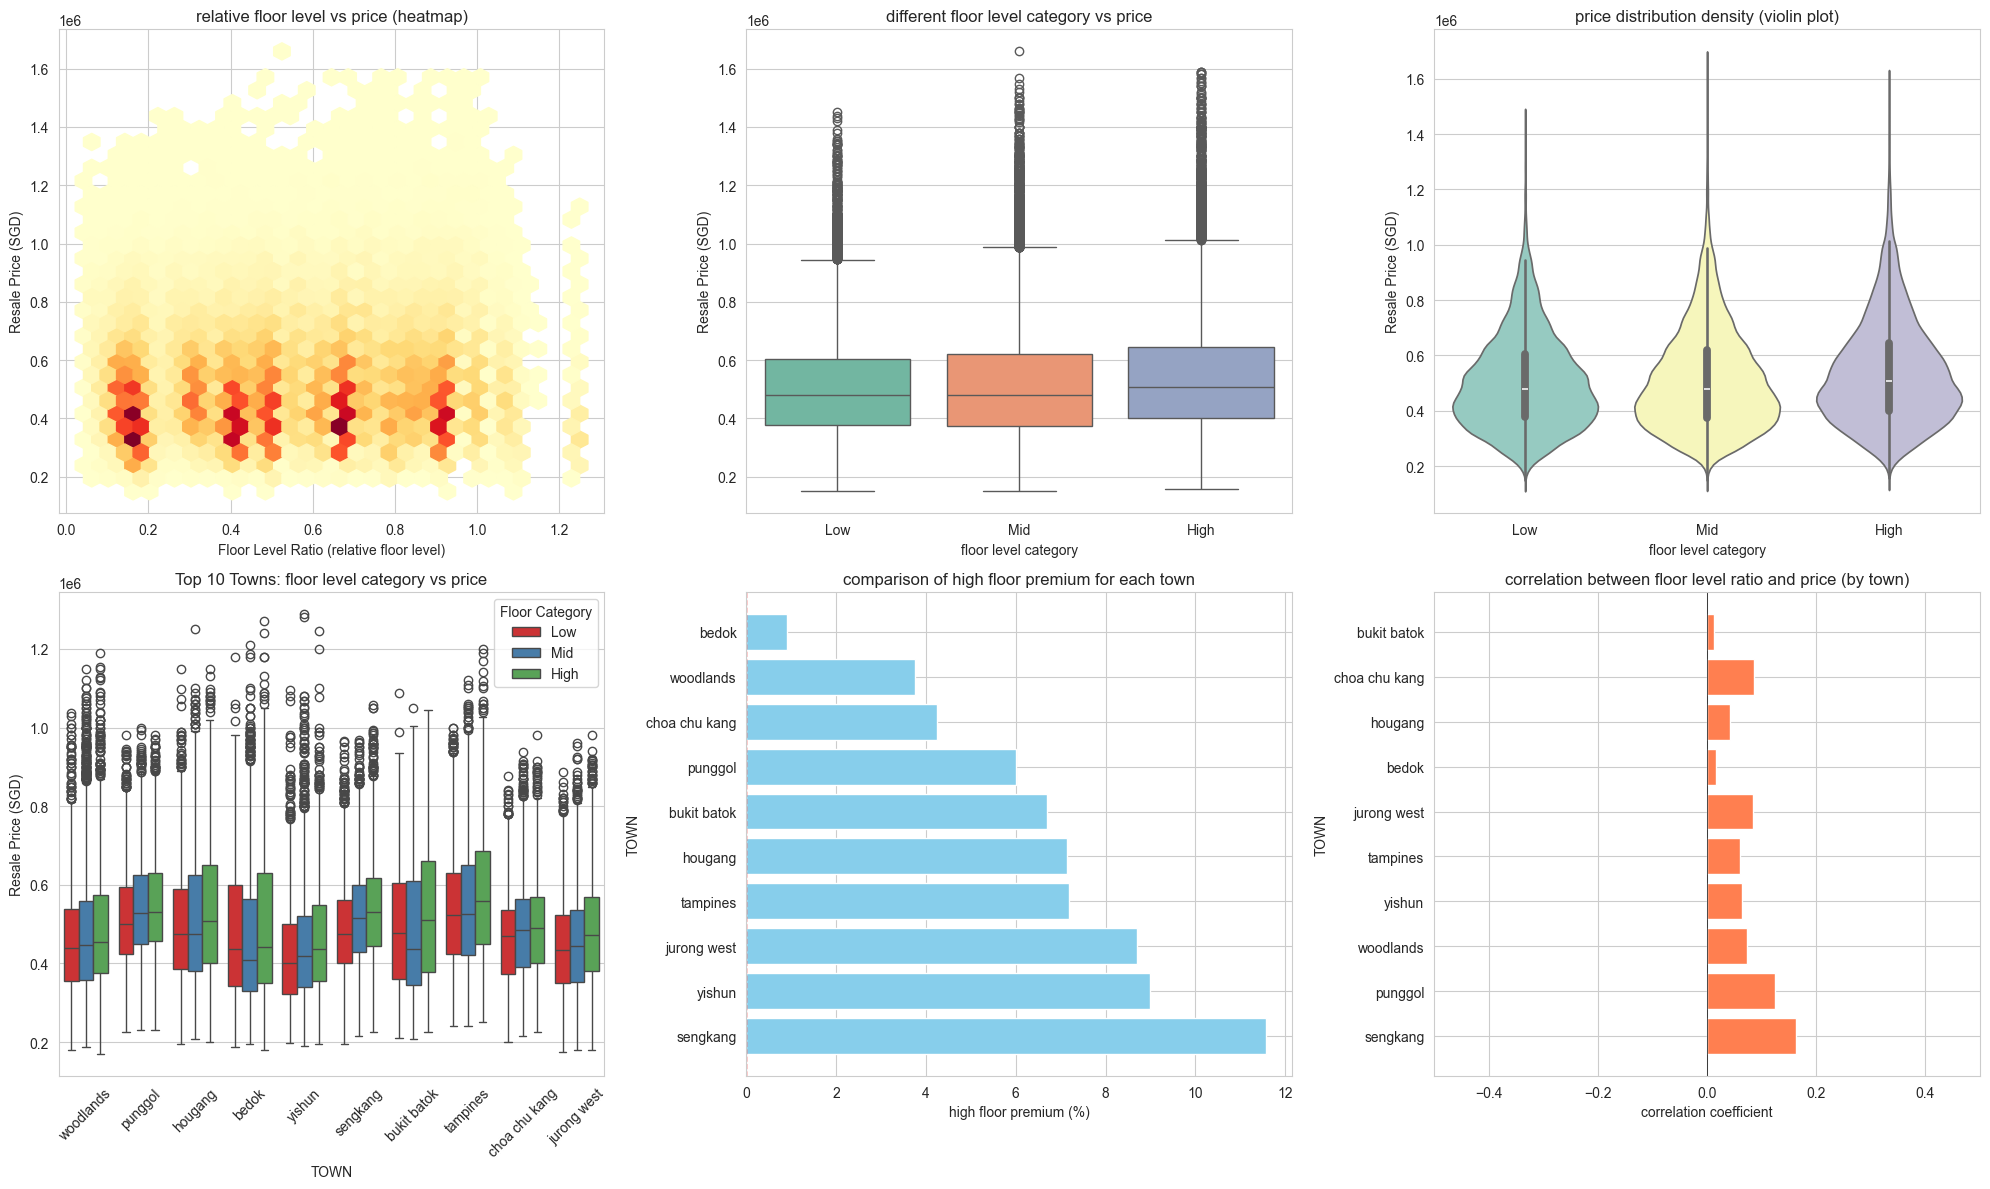

In [14]:

print("\n ===floor level vs price analysis===")

# 1. 
print("\n1. overall floor level vs price analysis")


# correlation analysis
correlation = df_processed_with_location[['FLOOR_LEVEL_RATIO', 'FLOOR_LEVEL_MID', 'RESALE_PRICE']].corr()
print("\n correlation matrix:")
print(correlation)

print("\n Based on floor level, the price statistics are:")
floor_stats = df_processed_with_location.groupby('FLOOR_LEVEL_CATEGORY')['RESALE_PRICE'].agg([
    ( 'count'),
    ( 'mean'),
    ('median'),
    ( 'std'),
    ('min'),
    ( 'max')
]).round(2)
print(floor_stats)


low_floor_median = df_processed_with_location[
    df_processed_with_location['FLOOR_LEVEL_CATEGORY'] == 'Low'
]['RESALE_PRICE'].median()
premium_list={}
for category in ['Mid', 'High']:
    cat_median = df_processed_with_location[
        df_processed_with_location['FLOOR_LEVEL_CATEGORY'] == category
    ]['RESALE_PRICE'].median()
    premium = ((cat_median - low_floor_median) / low_floor_median) * 100
    premium_list[category]=premium
    print(f"\n{category} Floor vs Low Floor premium: {premium:.2f}%")


fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 2.1 Floor level ratio vs price scatter plot
axes[0, 0].hexbin(
    df_processed_with_location['FLOOR_LEVEL_RATIO'], 
    df_processed_with_location['RESALE_PRICE'],
    gridsize=30, cmap='YlOrRd', mincnt=1
)
axes[0, 0].set_xlabel('Floor Level Ratio (relative floor level)')
axes[0, 0].set_ylabel('Resale Price (SGD)')
axes[0, 0].set_title('relative floor level vs price (heatmap)')

# 2.2 Boxplot of floor level category vs price
sns.boxplot(
    data=df_processed_with_location,
    x='FLOOR_LEVEL_CATEGORY',
    y='RESALE_PRICE',
    ax=axes[0, 1],
    palette='Set2'
)
axes[0, 1].set_xlabel('floor level category')
axes[0, 1].set_ylabel('Resale Price (SGD)')
axes[0, 1].set_title('different floor level category vs price')

# 2.3 Violin plot of floor level category vs price
sns.violinplot(
    data=df_processed_with_location,
    x='FLOOR_LEVEL_CATEGORY',
    y='RESALE_PRICE',
    ax=axes[0, 2],
    palette='Set3'
)
axes[0, 2].set_xlabel('floor level category')
axes[0, 2].set_ylabel('Resale Price (SGD)')
axes[0, 2].set_title('price distribution density (violin plot)')

# 3. Analysis by TOWN
print("\n" + "=" * 60)
print("2. Analysis by TOWN")
print("=" * 60)

# Choose transcation volume TOP 10 town
top_towns = df_processed_with_location['TOWN'].value_counts().head(10).index

# Calculate floor level premium for each town
town_floor_premium = []
for town in top_towns:
    town_data = df_processed_with_location[df_processed_with_location['TOWN'] == town]
    
    low_price = town_data[town_data['FLOOR_LEVEL_CATEGORY'] == 'Low']['RESALE_PRICE'].median()
    high_price = town_data[town_data['FLOOR_LEVEL_CATEGORY'] == 'High']['RESALE_PRICE'].median()
    
    if low_price > 0:
        premium = ((high_price - low_price) / low_price) * 100
        town_floor_premium.append({
            'TOWN': town,
            'LOW FLOOR MEDIAN': low_price,
            'HIGH FLOOR MEDIAN': high_price,
            'PREMIUM %': premium
        })

premium_df = pd.DataFrame(town_floor_premium).sort_values('PREMIUM %', ascending=False)
print("\nThe ranking of high floor premium for each town:")
print(premium_df.to_string(index=False))

# 3.2 Top Towns' floor level vs price
town_floor_data = df_processed_with_location[
    df_processed_with_location['TOWN'].isin(top_towns)
]

sns.boxplot(
    data=town_floor_data,
    x='TOWN',
    y='RESALE_PRICE',
    hue='FLOOR_LEVEL_CATEGORY',
    ax=axes[1, 0],
    palette='Set1'
)
axes[1, 0].set_xlabel('TOWN')
axes[1, 0].set_ylabel('Resale Price (SGD)')
axes[1, 0].set_title('Top 10 Towns: floor level category vs price')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(title='Floor Category')

# 3.3 Premium visualization
axes[1, 1].barh(premium_df['TOWN'], premium_df['PREMIUM %'], color='skyblue')
axes[1, 1].set_xlabel('high floor premium (%)')
axes[1, 1].set_ylabel('TOWN')
axes[1, 1].set_title('comparison of high floor premium for each town')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=1)

# 3.4 Correlation heatmap（by town）
town_floor_corr = []
for town in top_towns:
    town_data = df_processed_with_location[df_processed_with_location['TOWN'] == town]
    corr = town_data[['FLOOR_LEVEL_RATIO', 'RESALE_PRICE']].corr().iloc[0, 1]
    town_floor_corr.append(corr)

axes[1, 2].barh(top_towns, town_floor_corr, color='coral')
axes[1, 2].set_xlabel('correlation coefficient')
axes[1, 2].set_ylabel('TOWN')
axes[1, 2].set_title('correlation between floor level ratio and price (by town)')
axes[1, 2].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 2].set_xlim(-0.5, 0.5)

plt.tight_layout()
# plt.savefig('../Plots/floor_level_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
print("3. Statistical significance test")

low_prices = df_processed_with_location[
    df_processed_with_location['FLOOR_LEVEL_CATEGORY'] == 'Low'
]['RESALE_PRICE']
mid_prices = df_processed_with_location[
    df_processed_with_location['FLOOR_LEVEL_CATEGORY'] == 'Mid'
]['RESALE_PRICE']
high_prices = df_processed_with_location[
    df_processed_with_location['FLOOR_LEVEL_CATEGORY'] == 'High'
]['RESALE_PRICE']

h_stat, p_value = stats.kruskal(low_prices, mid_prices, high_prices)
print(f"\nKruskal-Wallis test:")
print(f"H-statistic: {h_stat:.4f}")
print(f"P-value: {p_value:.4e}")
if p_value < 0.05:
    print("Conclusion: there is a significant difference in price between different floor level categories")
else:
    print("Conclusion: there is no significant difference in price between different floor level categories")



3. Statistical significance test

Kruskal-Wallis test:
H-statistic: 857.3705
P-value: 6.6737e-187
Conclusion: there is a significant difference in price between different floor level categories


In [18]:
print("Key findings summary")

print("\n ===EDA core findings ===")
print(f"""
1. Linear relationship:
   - Absolute floor level vs price: 0.342 (medium positive correlation) 
   - Relative floor level vs price: 0.050 (almost no correlation) 
   Conclusion: In the Singapore HDB market, buyers focus more on the absolute floor level height

2. Non-linear feature of floor premium:
   - Low Floor (median): $480,000
   - Mid Floor (median): $480,000 (0% premium)
   - High Floor (median): $508,000 (5.83% premium) 
   Conclusion: Only high floor has significant premium, the price of mid and low floor is similar

3. Significant Town heterogeneity:
   - Highest premium (Sengkang): 11.58%
   - Lowest premium (Bedok):     0.91%
   - Difference ratio: 12.7x 
   Conclusion: Floor effect is highly dependent on Town

4. Statistical significance validation:
   - Kruskal-Wallis H-statistic: {h_stat:.4f}
   - P-value: {p_value:.4e}
   - Conclusion: There is a significant difference in price between different floor level categories (p<0.05)
""")

print("\n Modeling strategy suggestions")
print("""
Based on the above findings, the following feature engineering strategies are recommended:

Feature retention decision:
  1. Retain FLOOR_LEVEL_MID (absolute floor level) - Strong correlation
  2. Retain FLOOR_LEVEL_RATIO (relative floor level) - Weak correlation, but may have non-linear effect
  3. Exclude FLOOR_LEVEL_CATEGORY - Only used for EDA, replaced with numerical values in modeling

New derived features:
  1. IS_HIGH_FLOOR - Capture the non-linear effect of "high floor premium"
     └─ Definition: FLOOR_LEVEL_MID >= threshold (based on absolute floor level)
     
  2. IS_HIGH_FLOOR_IN_PREMIUM_TOWN - Capture the Town-specific floor effect
     └─ Definition: IS_HIGH_FLOOR & TOWN in high_premium_towns
     └─ Reason: Floor effect varies significantly across Towns
  
Modeling method suggestions:
  1. Prioritize tree models (RF, XGBoost, LightGBM)
     └─ Reason: Can automatically capture non-linear and interaction effects
     
  2. If using linear models, manually create more interaction features
     └─ Example: FLOOR_MID × TOWN_XXX interaction features
""")

Key findings summary

 ===EDA core findings ===

1. Linear relationship:
   - Absolute floor level vs price: 0.342 (medium positive correlation) 
   - Relative floor level vs price: 0.050 (almost no correlation) 
   Conclusion: In the Singapore HDB market, buyers focus more on the absolute floor level height

2. Non-linear feature of floor premium:
   - Low Floor (median): $480,000
   - Mid Floor (median): $480,000 (0% premium)
   - High Floor (median): $508,000 (5.83% premium) 
   Conclusion: Only high floor has significant premium, the price of mid and low floor is similar

3. Significant Town heterogeneity:
   - Highest premium (Sengkang): 11.58%
   - Lowest premium (Bedok):     0.91%
   - Difference ratio: 12.7x 
   Conclusion: Floor effect is highly dependent on Town

4. Statistical significance validation:
   - Kruskal-Wallis H-statistic: 855.2240
   - P-value: 1.9519e-186
   - Conclusion: There is a significant difference in price between different floor level categories (p<0.05

In [16]:
##Add derived feature
df_processed_with_location['IS_HIGH_FLOOR']=(df_processed_with_location['FLOOR_LEVEL_CATEGORY']=='High').astype(int)
high_premium_towns=premium_df['TOWN'].head(5).to_list()
df_processed_with_location['IS_HIGH_FLOOR_IN_PREMIUM_TOWN']=(df_processed_with_location['IS_HIGH_FLOOR']&df_processed_with_location['TOWN'].isin(high_premium_towns)).astype(int)
df_processed_with_location.columns.tolist()

['MONTH',
 'TOWN',
 'FLAT_TYPE',
 'BLOCK',
 'STREET',
 'FLOOR_RANGE',
 'FLOOR_AREA_SQM',
 'FLAT_MODEL',
 'ECO_CATEGORY',
 'LEASE_COMMENCE_DATA',
 'RESALE_PRICE',
 'LOG_RESALE_PRICE',
 'YEAR',
 'MONTH_NUM',
 'TRANSACTION_YEAR',
 'TRANSACTION_MONTH',
 'REMAINING_AGE',
 'FLOOR_LEVEL_LOW',
 'FLOOR_LEVEL_HIGH',
 'FLOOR_LEVEL_MID',
 'PRICE_PER_SQM',
 'FLAT_TYPE_CATEGORY',
 'TOWN_CATEGORY',
 'FLAT_TYPE_ENCODED',
 'FLAT_MODEL_2 room',
 'FLAT_MODEL_3gen',
 'FLAT_MODEL_adjoined flat',
 'FLAT_MODEL_apartment',
 'FLAT_MODEL_dbss',
 'FLAT_MODEL_improved',
 'FLAT_MODEL_improved maisonette',
 'FLAT_MODEL_maisonette',
 'FLAT_MODEL_model a',
 'FLAT_MODEL_model a maisonette',
 'FLAT_MODEL_model a2',
 'FLAT_MODEL_multi generation',
 'FLAT_MODEL_new generation',
 'FLAT_MODEL_premium apartment',
 'FLAT_MODEL_premium apartment loft',
 'FLAT_MODEL_premium maisonette',
 'FLAT_MODEL_simplified',
 'FLAT_MODEL_standard',
 'FLAT_MODEL_terrace',
 'FLAT_MODEL_type s1',
 'FLAT_MODEL_type s2',
 'TOWN_ang mo kio',
 'T

In [17]:
import sys
sys.path.append('../Utils')
from tools import *
hdb_coords=df_processed_with_location[['LATITUDE','LONGITUDE']]
print(f"hdb_coords shape: {hdb_coords.shape[0]}")


hdb_coords shape: 162691


In [18]:
print("\n===Calculate mrt related features===")

mrt_features=create_auxiliary_location_features(
    hdb_coords=hdb_coords,
    auxilliary_df=df_mrt,
    feature_prefix='MRT',
    radii=[0.5,1.0,2.0],
    batch_size=1000
)
mrt_features.head(10)


===Calculate mrt related features===


Creating mall features:   0%|          | 0/163 [00:00<?, ?it/s]

,NEAREST_MRT_KM,MRT_COUNT_0.5KM,MRT_COUNT_1.0KM,MRT_COUNT_2.0KM
0,0.306014,1,1,4
1,0.786298,0,1,10
2,1.052540,0,0,3
3,0.872296,0,2,7
4,1.342862,0,0,4
5,0.394178,2,2,6
6,1.293961,0,0,3
7,0.796545,0,2,8
8,0.282067,2,2,5
9,1.126586,0,0,2


In [19]:
print("\n===Calculate hawker related features===")

hawker_features=create_auxiliary_location_features(
    hdb_coords=hdb_coords,
    auxilliary_df=df_hawker,
    radii=[0.5,1.5,3.0],
    feature_prefix='HAWKER',
)
hawker_features.head(10)


===Calculate hawker related features===


,NEAREST_HAWKER_KM,HAWKER_COUNT_0.5KM,HAWKER_COUNT_1.5KM,HAWKER_COUNT_3.0KM
0,2.683955,0,0,3
1,0.916936,0,4,18
2,5.364143,0,0,0
3,4.563651,0,0,0
4,2.921355,0,0,1
5,0.474206,1,4,9
6,5.061361,0,0,0
7,0.285452,1,7,10
8,5.040068,0,0,0
9,2.043226,0,0,1


In [20]:
print("\n===Calculate malls related features===")

mall_features=create_auxiliary_location_features(
    hdb_coords=hdb_coords,
    auxilliary_df=df_malls,
    radii=[1.0,2.0,3.0],
    feature_prefix='MALL',
)
mall_features.head(10)


===Calculate malls related features===


,NEAREST_MALL_KM,MALL_COUNT_1.0KM,MALL_COUNT_2.0KM,MALL_COUNT_3.0KM
0,1.994702,0,1,3
1,1.176139,0,3,4
2,0.980543,1,1,2
3,0.463143,1,4,5
4,0.851672,1,2,4
5,0.493889,1,2,3
6,1.345992,0,1,2
7,1.589524,0,2,7
8,0.138165,2,3,4
9,1.162062,0,1,2


In [21]:
print("\n===Calculate primary school related features===")

primary_features=create_auxiliary_location_features(
    hdb_coords=hdb_coords,
    auxilliary_df=df_primary,
    radii=[1.0,2.0,3.0],
    feature_prefix='PRIMARY',
)
primary_features.head(10)



===Calculate primary school related features===


,NEAREST_PRIMARY_KM,PRIMARY_COUNT_1.0KM,PRIMARY_COUNT_2.0KM,PRIMARY_COUNT_3.0KM
0,0.168452,4,10,16
1,0.532114,1,9,17
2,0.156784,5,7,14
3,0.177318,6,15,22
4,0.812018,3,13,20
5,0.157509,3,5,8
6,0.240867,4,6,11
7,0.253732,3,11,18
8,0.298502,5,12,20
9,0.240205,3,9,10


In [22]:
print("\n===Calculate secondary school related features===")

secondary_features=create_auxiliary_location_features(
    hdb_coords=hdb_coords,
    auxilliary_df=df_secondary,
    radii=[1.0,2.0,3.0],
    feature_prefix='SECONDARY',
)
secondary_features.head(10)


===Calculate secondary school related features===


,NEAREST_SECONDARY_KM,SECONDARY_COUNT_1.0KM,SECONDARY_COUNT_2.0KM,SECONDARY_COUNT_3.0KM
0,0.268534,2,8,10
1,0.404944,3,11,18
2,0.238378,2,5,8
3,0.522089,3,7,11
4,0.594226,2,7,15
5,0.699133,2,6,9
6,0.795816,1,5,6
7,0.153394,4,10,14
8,0.386222,1,6,10
9,0.296811,3,7,8


In [23]:
print("\nCombine all distance features...")
df_processed_with_location = df_processed_with_location.join([
    mrt_features,
    hawker_features,
    primary_features,
    secondary_features,
    mall_features
])
print(f"\nFinal data shape: {df_processed_with_location.shape}")
print("\nNew Columns:")
print(df_processed_with_location.columns.tolist()[-16:]) 

print("\nDistance features statistics:")
distance_cols = [col for col in df_processed_with_location.columns if 'NEAREST' in col or 'COUNT' in col]
print(df_processed_with_location[distance_cols].describe())


Combine all distance features...

Final data shape: (162691, 110)

New Columns:
['NEAREST_HAWKER_KM', 'HAWKER_COUNT_0.5KM', 'HAWKER_COUNT_1.5KM', 'HAWKER_COUNT_3.0KM', 'NEAREST_PRIMARY_KM', 'PRIMARY_COUNT_1.0KM', 'PRIMARY_COUNT_2.0KM', 'PRIMARY_COUNT_3.0KM', 'NEAREST_SECONDARY_KM', 'SECONDARY_COUNT_1.0KM', 'SECONDARY_COUNT_2.0KM', 'SECONDARY_COUNT_3.0KM', 'NEAREST_MALL_KM', 'MALL_COUNT_1.0KM', 'MALL_COUNT_2.0KM', 'MALL_COUNT_3.0KM']

Distance features statistics:
       NEAREST_MRT_KM  MRT_COUNT_0.5KM  MRT_COUNT_1.0KM  MRT_COUNT_2.0KM  \
count   162691.000000    162691.000000    162691.000000    162691.000000   
mean         0.664665         0.526679         1.997892         6.557886   
std          0.374114         0.802927         1.490990         3.483944   
min          0.021845         0.000000         0.000000         0.000000   
25%          0.405522         0.000000         1.000000         5.000000   
50%          0.600716         0.000000         2.000000         6.000000   

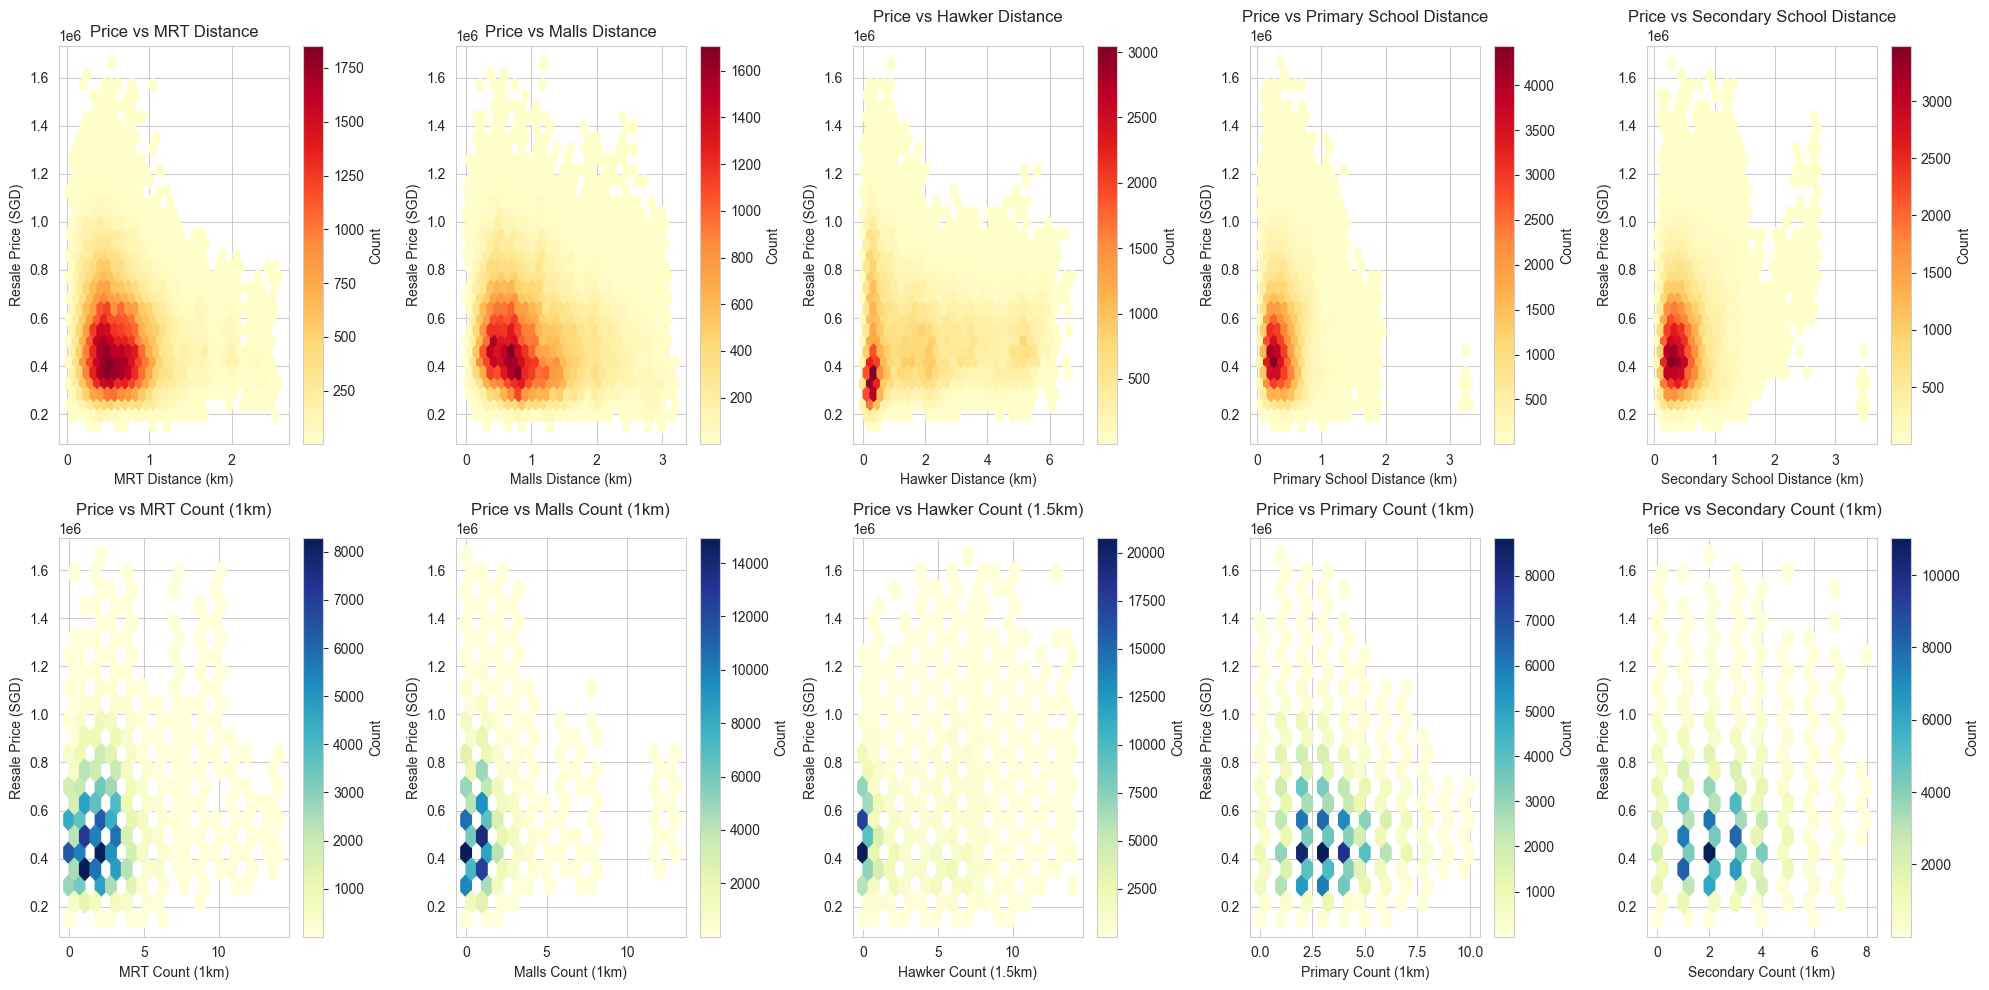

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Distance vs Price
distances = ['NEAREST_MRT_KM', 'NEAREST_MALL_KM', 'NEAREST_HAWKER_KM', 
             'NEAREST_PRIMARY_KM', 'NEAREST_SECONDARY_KM']
titles_dist = ['MRT Distance', 'Malls Distance', 'Hawker Distance', 
               'Primary School Distance', 'Secondary School Distance']

for idx, (col, title) in enumerate(zip(distances, titles_dist)):
    hb = axes[0, idx].hexbin(
        df_processed_with_location[col], 
        df_processed_with_location['RESALE_PRICE'],
        gridsize=30, cmap='YlOrRd', mincnt=1
    )
    axes[0, idx].set_xlabel(f'{title} (km)')
    axes[0, idx].set_ylabel('Resale Price (SGD)')
    axes[0, idx].set_title(f'Price vs {title}')
    plt.colorbar(hb, ax=axes[0, idx], label='Count')

# Density vs Price
counts = ['MRT_COUNT_1.0KM', 'MALL_COUNT_1.0KM', 'HAWKER_COUNT_1.5KM', 
          'PRIMARY_COUNT_1.0KM', 'SECONDARY_COUNT_1.0KM']
titles_count = ['MRT Count (1km)', 'Malls Count (1km)', 'Hawker Count (1.5km)', 
                'Primary Count (1km)', 'Secondary Count (1km)']

for idx, (col, title) in enumerate(zip(counts, titles_count)):
    hb = axes[1, idx].hexbin(
        df_processed_with_location[col], 
        df_processed_with_location['RESALE_PRICE'],
        gridsize=20, cmap='YlGnBu', mincnt=1
    )
    axes[1, idx].set_xlabel(title)
    axes[1, idx].set_ylabel('Resale Price (SGD)')
    axes[1, idx].set_title(f'Price vs {title}')
    plt.colorbar(hb, ax=axes[1, idx], label='Count')

plt.tight_layout()
plt.show()

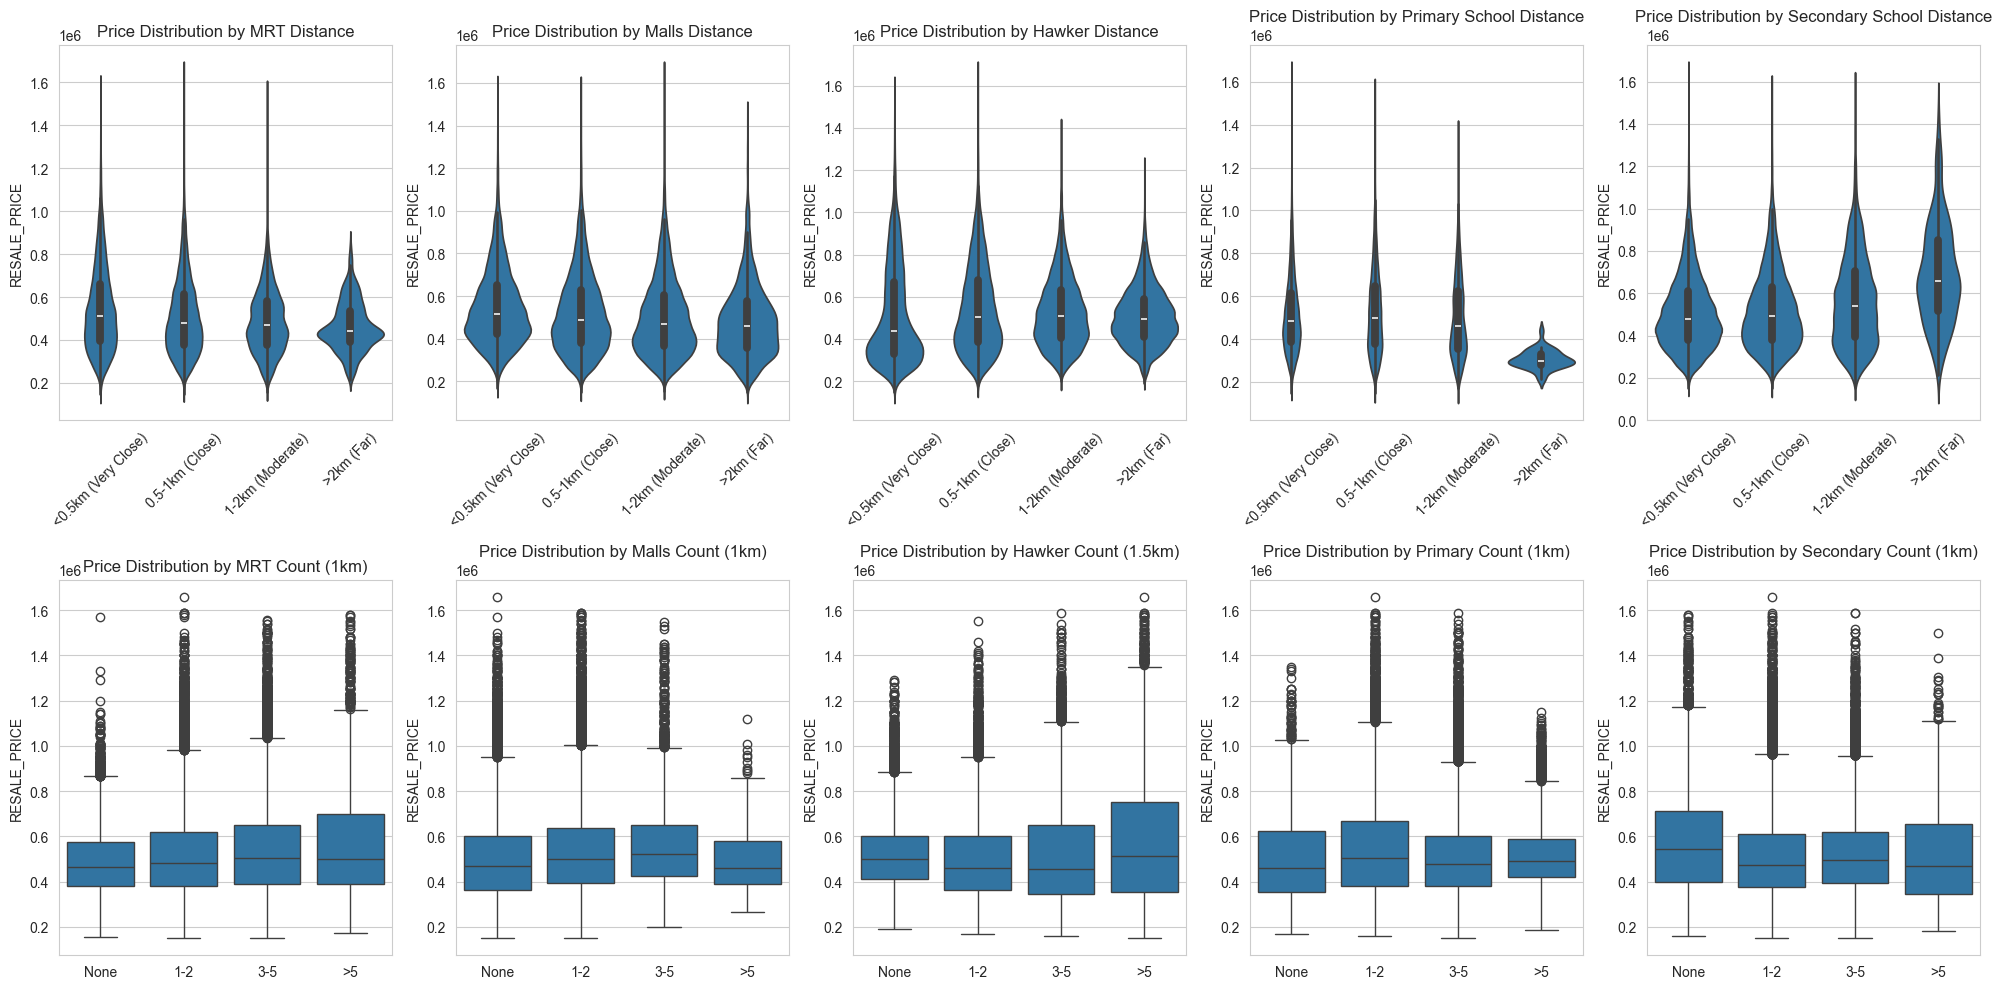

In [30]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

#Categorize distance
def categorize_distance(dist):
    if pd.isna(dist): return 'Unknown'
    elif dist < 0.5: return '<0.5km (Very Close)'
    elif dist < 1.0: return '0.5-1km (Close)'
    elif dist < 2.0: return '1-2km (Moderate)'
    else: return '>2km (Far)'


for idx, (col, title) in enumerate(zip(distances, titles_dist)):
    df_temp = df_processed_with_location.copy()
    df_temp['distance_cat'] = df_temp[col].apply(categorize_distance)
    
    sns.violinplot(
        data=df_temp,
        x='distance_cat', y='RESALE_PRICE',
        ax=axes[0, idx],
        order=['<0.5km (Very Close)', '0.5-1km (Close)', 
               '1-2km (Moderate)', '>2km (Far)']
    )
    axes[0, idx].set_title(f'Price Distribution by {title}')
    axes[0, idx].set_xlabel('')
    axes[0, idx].tick_params(axis='x', rotation=45)

#Categorize density
def categorize_count(count):
    if pd.isna(count): return 'Unknown'
    elif count == 0: return 'None'
    elif count <= 2: return '1-2'
    elif count <= 5: return '3-5'
    else: return '>5'

for idx, (col, title) in enumerate(zip(counts, titles_count)):
    df_temp = df_processed_with_location.copy()
    df_temp['count_cat'] = df_temp[col].apply(categorize_count)
    
    sns.boxplot(
        data=df_temp,
        x='count_cat', y='RESALE_PRICE',
        ax=axes[1, idx],
        order=['None', '1-2', '3-5', '>5']
    )
    axes[1, idx].set_title(f'Price Distribution by {title}')
    axes[1, idx].set_xlabel('')

plt.tight_layout()
plt.show()

=== MRT Proximity Analysis ===

Median price by MRT proximity:
MRT_COUNT_1.0KM
<2 MRTs     470000.0
>=2 MRTs    500000.0
Name: RESALE_PRICE, dtype: float64


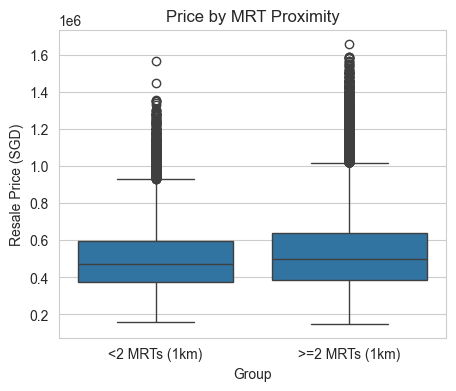


Median price by MRT distance:
NEAREST_MRT_KM
>0.5km     475000.0
<=0.5km    510000.0
Name: RESALE_PRICE, dtype: float64


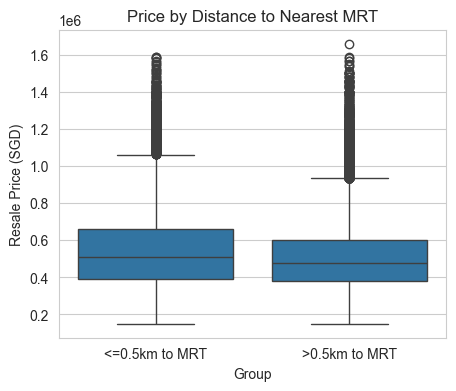

In [31]:
sub = df_processed_with_location.dropna(subset=['LATITUDE', 'LONGITUDE', 'RESALE_PRICE'])

# ============================================
# 1. MRT 
# ============================================
print("=== MRT Proximity Analysis ===")

# 1.2 Boxplot based on MRT density
mask_mrt = sub['MRT_COUNT_1.0KM'] >= 2
print('\nMedian price by MRT proximity:')
print(sub.groupby(mask_mrt)['RESALE_PRICE'].median().rename({False:'<2 MRTs', True:'>=2 MRTs'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt, '>=2 MRTs (1km)', '<2 MRTs (1km)')),
            x='group', y='RESALE_PRICE')
plt.title('Price by MRT Proximity')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_proximity.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.3 Boxplot based on MRT distance
mask_mrt_dist = sub['NEAREST_MRT_KM'] <= 0.5
print('\nMedian price by MRT distance:')
print(sub.groupby(mask_mrt_dist)['RESALE_PRICE'].median().rename({False:'>0.5km', True:'<=0.5km'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt_dist, '<=0.5km to MRT', '>0.5km to MRT')),
            x='group', y='RESALE_PRICE')
plt.title('Price by Distance to Nearest MRT')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_distance.png', dpi=300, bbox_inches='tight')
plt.show()

=== HAWKERS Proximity Analysis ===

Median price by HAWKERS proximity:
HAWKER_COUNT_3.0KM
<2 HAWKERS     495000.0
>=2 HAWKERS    480000.0
Name: RESALE_PRICE, dtype: float64


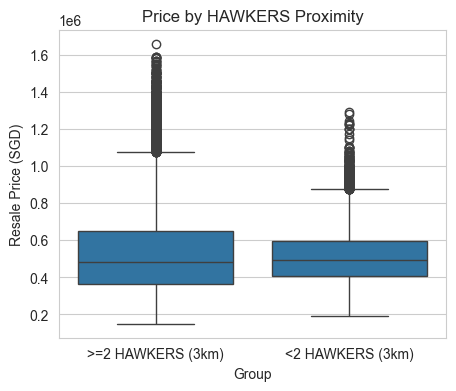


Median price by HAWKERS distance:
NEAREST_HAWKER_KM
>3km     500888.0
<=3km    480000.0
Name: RESALE_PRICE, dtype: float64


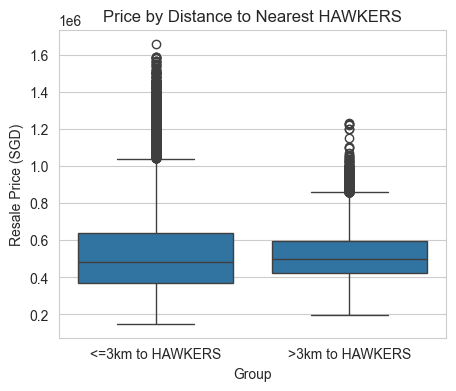

In [31]:
# ============================================
# 2. HAWKERS
# ============================================
print("=== HAWKERS Proximity Analysis ===")


# 2.1 Boxplot based on HAWKERS density
mask_mrt = sub['HAWKER_COUNT_3.0KM'] >= 2
print('\nMedian price by HAWKERS proximity:')
print(sub.groupby(mask_mrt)['RESALE_PRICE'].median().rename({False:'<2 HAWKERS', True:'>=2 HAWKERS'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt, '>=2 HAWKERS (3km)', '<2 HAWKERS (3km)')),
            x='group', y='RESALE_PRICE')
plt.title('Price by HAWKERS Proximity')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_proximity.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.3 Boxplot based on HAWKERS distance
mask_mrt_dist = sub['NEAREST_HAWKER_KM'] <= 3.0
print('\nMedian price by HAWKERS distance:')
print(sub.groupby(mask_mrt_dist)['RESALE_PRICE'].median().rename({False:'>3km', True:'<=3km'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt_dist, '<=3km to HAWKERS', '>3km to HAWKERS')),
            x='group', y='RESALE_PRICE')
plt.title('Price by Distance to Nearest HAWKERS')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_distance.png', dpi=300, bbox_inches='tight')
plt.show()

=== Primary School Proximity Analysis ===

Median price by Primary School proximity:
PRIMARY_COUNT_1.0KM
<2 Primary Schools     518000.0
>=2 Primary Schools    485000.0
Name: RESALE_PRICE, dtype: float64


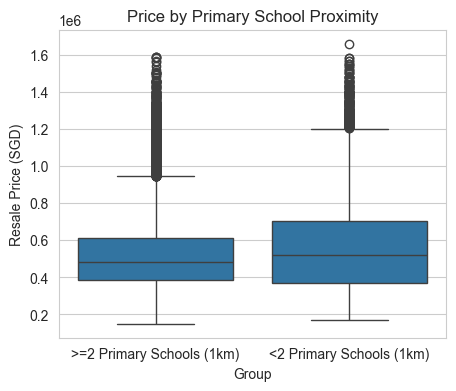


Median price by Primary School distance:
NEAREST_PRIMARY_KM
>1km     460000.0
<=1km    488000.0
Name: RESALE_PRICE, dtype: float64


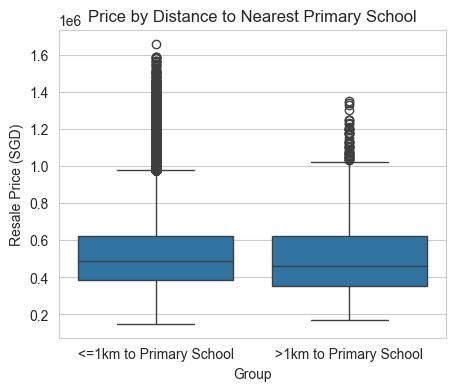

In [32]:
# ============================================
# 3. Primary School 
# ============================================
print("=== Primary School Proximity Analysis ===")


#3.1 Primary School density boxplot
mask_mrt = sub['PRIMARY_COUNT_1.0KM'] >= 2
print('\nMedian price by Primary School proximity:')
print(sub.groupby(mask_mrt)['RESALE_PRICE'].median().rename({False:'<2 Primary Schools', True:'>=2 Primary Schools'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt, '>=2 Primary Schools (1km)', '<2 Primary Schools (1km)')),
            x='group', y='RESALE_PRICE')
plt.title('Price by Primary School Proximity')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_proximity.png', dpi=300, bbox_inches='tight')
plt.show()

#3.2 distance category boxplot
mask_mrt_dist = sub['NEAREST_PRIMARY_KM'] <= 1.0
print('\nMedian price by Primary School distance:')
print(sub.groupby(mask_mrt_dist)['RESALE_PRICE'].median().rename({False:'>1km', True:'<=1km'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt_dist, '<=1km to Primary School', '>1km to Primary School')),
            x='group', y='RESALE_PRICE')
plt.title('Price by Distance to Nearest Primary School')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_distance.png', dpi=300, bbox_inches='tight')
plt.show()

=== Secondary School Proximity Analysis ===

Median price by Secondary School proximity:
SECONDARY_COUNT_1.0KM
<2 Secondary Schools     490000.0
>=2 Secondary Schools    485000.0
Name: RESALE_PRICE, dtype: float64


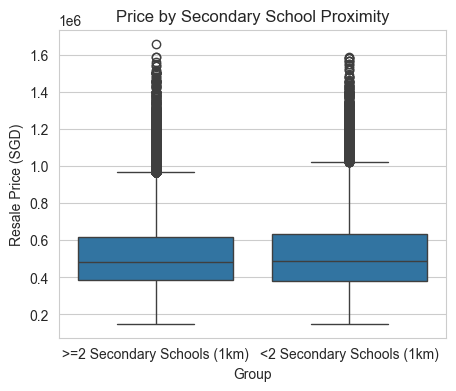


Median price by Secondary School distance:
NEAREST_SECONDARY_KM
>1km     545000.0
<=1km    482000.0
Name: RESALE_PRICE, dtype: float64


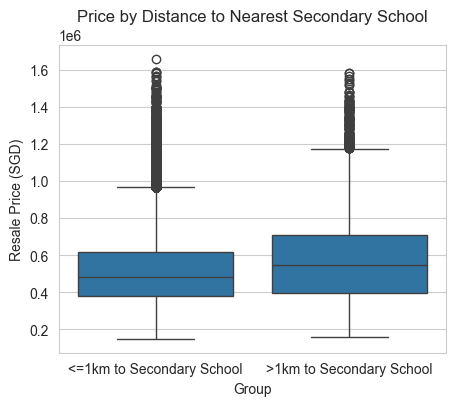

In [33]:
# ============================================
# 4. Secondary School
# ============================================
print("=== Secondary School Proximity Analysis ===")


#4.1 Boxplot based on Secondary School density
mask_mrt = sub['SECONDARY_COUNT_1.0KM'] >= 2
print('\nMedian price by Secondary School proximity:')
print(sub.groupby(mask_mrt)['RESALE_PRICE'].median().rename({False:'<2 Secondary Schools', True:'>=2 Secondary Schools'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt, '>=2 Secondary Schools (1km)', '<2 Secondary Schools (1km)')),
            x='group', y='RESALE_PRICE')
plt.title('Price by Secondary School Proximity')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_proximity.png', dpi=300, bbox_inches='tight')
plt.show()

#4.2 Boxplot based on Secondary School distance
mask_mrt_dist = sub['NEAREST_SECONDARY_KM'] <= 1.0
print('\nMedian price by Secondary School distance:')
print(sub.groupby(mask_mrt_dist)['RESALE_PRICE'].median().rename({False:'>1km', True:'<=1km'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt_dist, '<=1km to Secondary School', '>1km to Secondary School')),
            x='group', y='RESALE_PRICE')
plt.title('Price by Distance to Nearest Secondary School')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_distance.png', dpi=300, bbox_inches='tight')
plt.show()

=== Malls Proximity Analysis ===

Median price by Malls proximity:
MALL_COUNT_1.0KM
<2 Malls     483000.0
>=2 Malls    505000.0
Name: RESALE_PRICE, dtype: float64


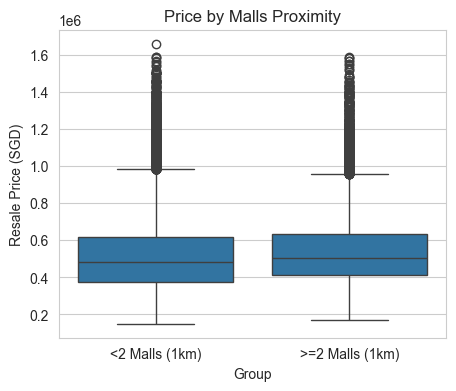


Median price by Malls distance:
NEAREST_MALL_KM
>1km     468000.0
<=1km    500000.0
Name: RESALE_PRICE, dtype: float64


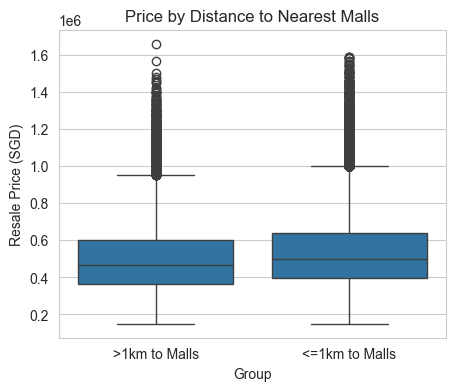

In [34]:
# ============================================
# 5. Malls
# ============================================
print("=== Malls Proximity Analysis ===")


#4.1 Boxplot based on Malls density
mask_mrt = sub['MALL_COUNT_1.0KM'] >= 2
print('\nMedian price by Malls proximity:')
print(sub.groupby(mask_mrt)['RESALE_PRICE'].median().rename({False:'<2 Malls', True:'>=2 Malls'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt, '>=2 Malls (1km)', '<2 Malls (1km)')),
            x='group', y='RESALE_PRICE')
plt.title('Price by Malls Proximity')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_proximity.png', dpi=300, bbox_inches='tight')
plt.show()

#4.2 Boxplot based on Malls distance
mask_mrt_dist = sub['NEAREST_MALL_KM'] <= 1.0
print('\nMedian price by Malls distance:')
print(sub.groupby(mask_mrt_dist)['RESALE_PRICE'].median().rename({False:'>1km', True:'<=1km'}))

plt.figure(figsize=(5, 4))
sns.boxplot(data=sub.assign(group=np.where(mask_mrt_dist, '<=1km to Malls', '>1km to Malls')),
            x='group', y='RESALE_PRICE')
plt.title('Price by Distance to Nearest Malls')
plt.xlabel('Group')
plt.ylabel('Resale Price (SGD)')
# plt.savefig('../Plots/boxplot_price_mrt_distance.png', dpi=300, bbox_inches='tight')
plt.show()

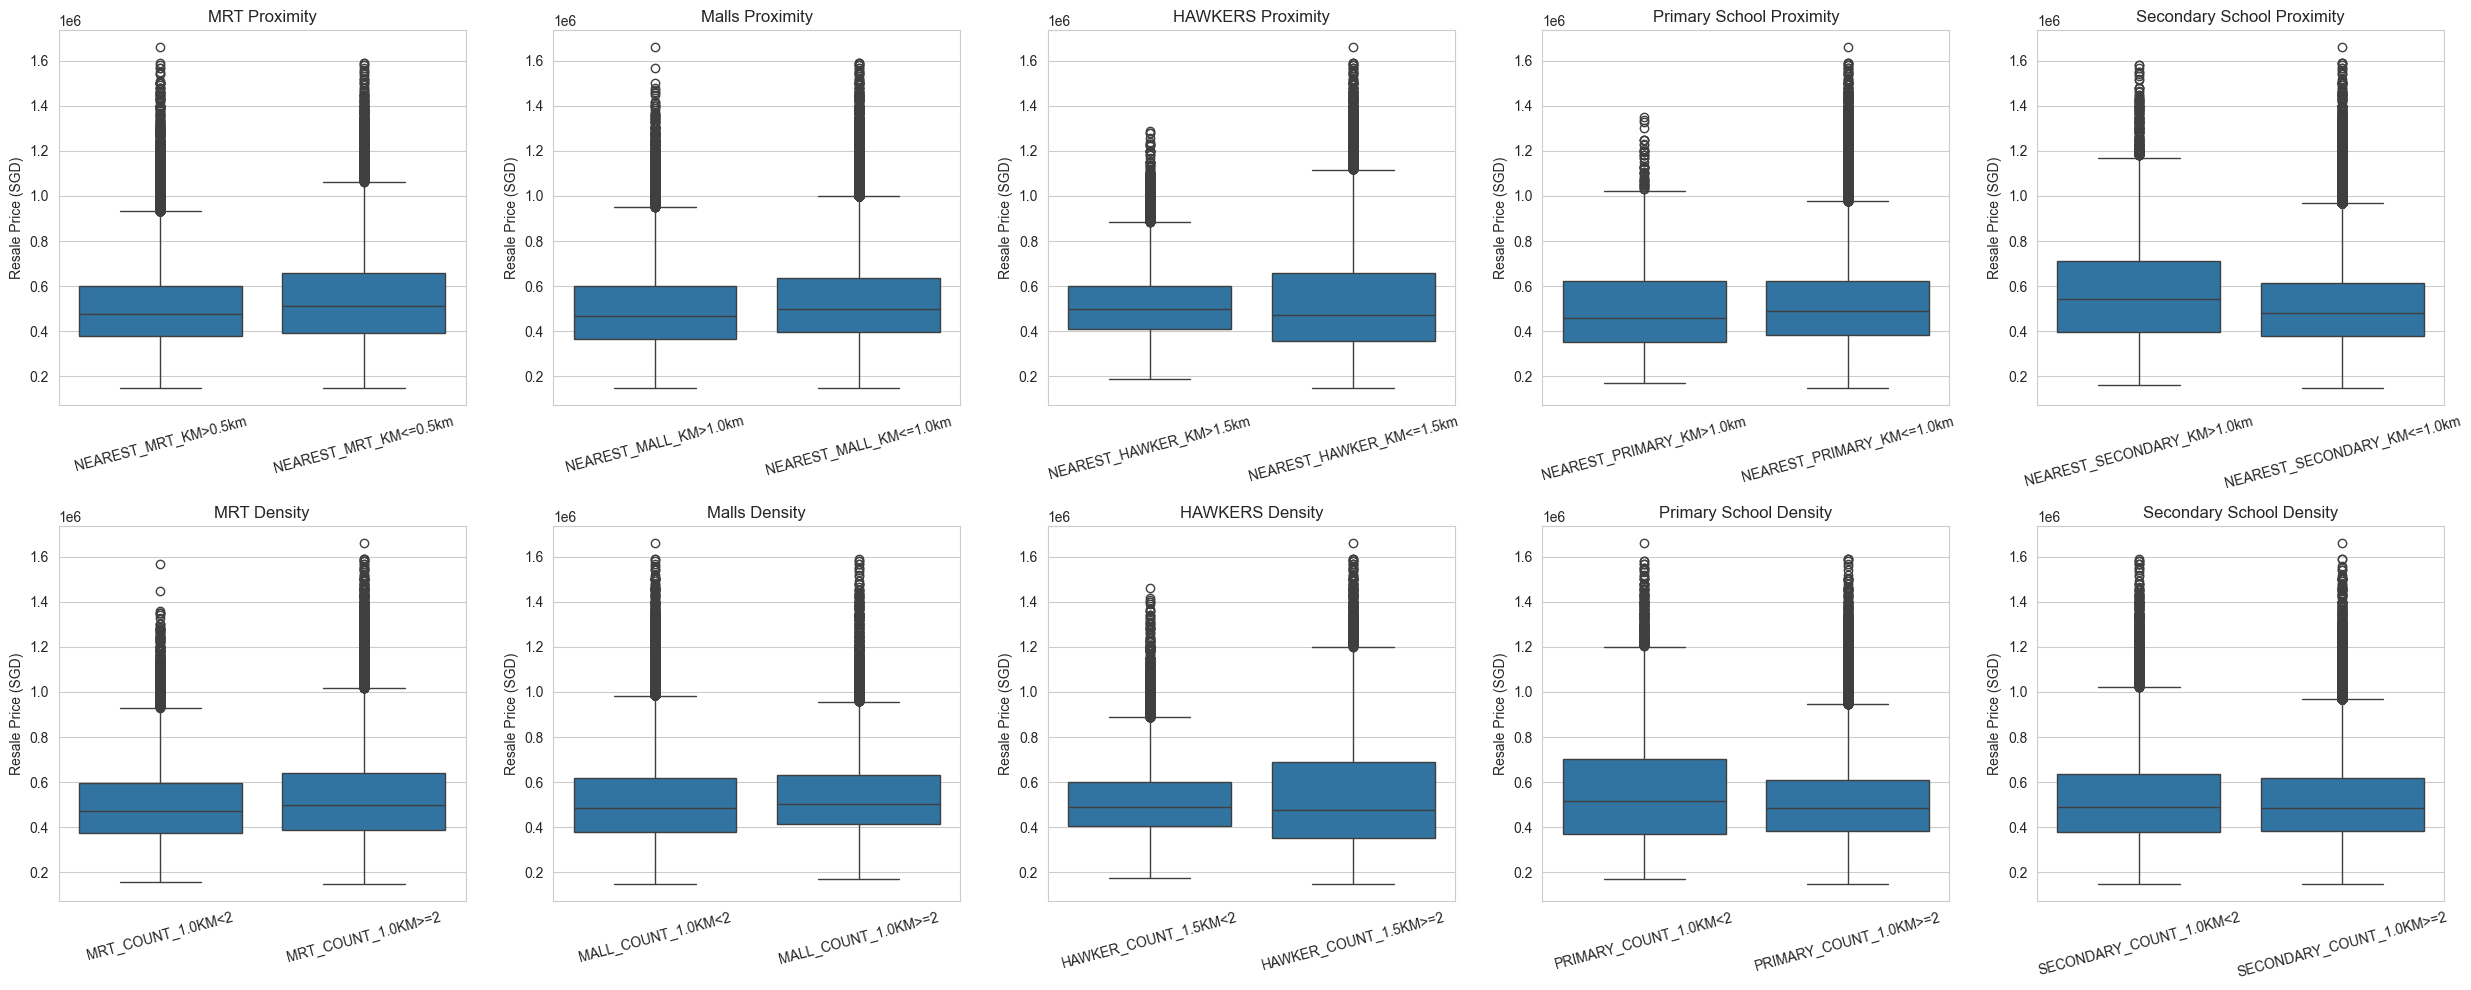

In [35]:
fig,axes=plt.subplots(2,5,figsize=(25,10))
amenities=[
    {'name':'MRT','proximity':'NEAREST_MRT_KM','density':'MRT_COUNT_1.0KM',
    'proximity_threshold':0.5,'density_threshold':2,'proximity_unit':'km'},
    {'name':'Malls','proximity':'NEAREST_MALL_KM','density':'MALL_COUNT_1.0KM',
    'proximity_threshold':1.0,'density_threshold':2,'proximity_unit':'km'},
    {'name':'HAWKERS','proximity':'NEAREST_HAWKER_KM','density':'HAWKER_COUNT_1.5KM',
    'proximity_threshold':1.5,'density_threshold':2,'proximity_unit':'km'},
    {'name':'Primary School','proximity':'NEAREST_PRIMARY_KM','density':'PRIMARY_COUNT_1.0KM',
    'proximity_threshold':1.0,'density_threshold':2,'proximity_unit':'km'},
    {'name':'Secondary School','proximity':'NEAREST_SECONDARY_KM','density':'SECONDARY_COUNT_1.0KM',
    'proximity_threshold':1.0,'density_threshold':2,'proximity_unit':'km'},
    ]
for col_idx, amenity in enumerate(amenities):
    mask_proximity=sub[amenity['proximity']]<=amenity['proximity_threshold']
    label_far=f'{amenity["proximity"]}>{amenity["proximity_threshold"]}{amenity["proximity_unit"]}'
    label_close=f'{amenity["proximity"]}<={amenity["proximity_threshold"]}{amenity["proximity_unit"]}'

    sns.boxplot(ax=axes[0,col_idx],data=sub.assign(group=np.where(mask_proximity,label_close,label_far)),x='group',
    y='RESALE_PRICE',order=[label_far,label_close])
    axes[0,col_idx].set_title(f'{amenity["name"]} Proximity')
    axes[0,col_idx].set_xlabel('')
    axes[0,col_idx].set_ylabel('Resale Price (SGD)')
    axes[0, col_idx].tick_params(axis='x', rotation=15)

    mask_density=sub[amenity['density']]>=amenity['density_threshold']
    label_high=f'{amenity["density"]}>={amenity["density_threshold"]}'
    label_low=f'{amenity["density"]}<{amenity["density_threshold"]}'

    sns.boxplot(ax=axes[1,col_idx],data=sub.assign(group=np.where(mask_density,label_high,label_low)),x='group',
    y='RESALE_PRICE',order=[label_low,label_high])
    axes[1,col_idx].set_title(f'{amenity["name"]} Density')
    axes[1,col_idx].set_xlabel('')
    axes[1,col_idx].set_ylabel('Resale Price (SGD)')
    axes[1,col_idx].tick_params(axis='x', rotation=15)
plt.savefig('../Plots/amenity_proximity_density_analysis.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()




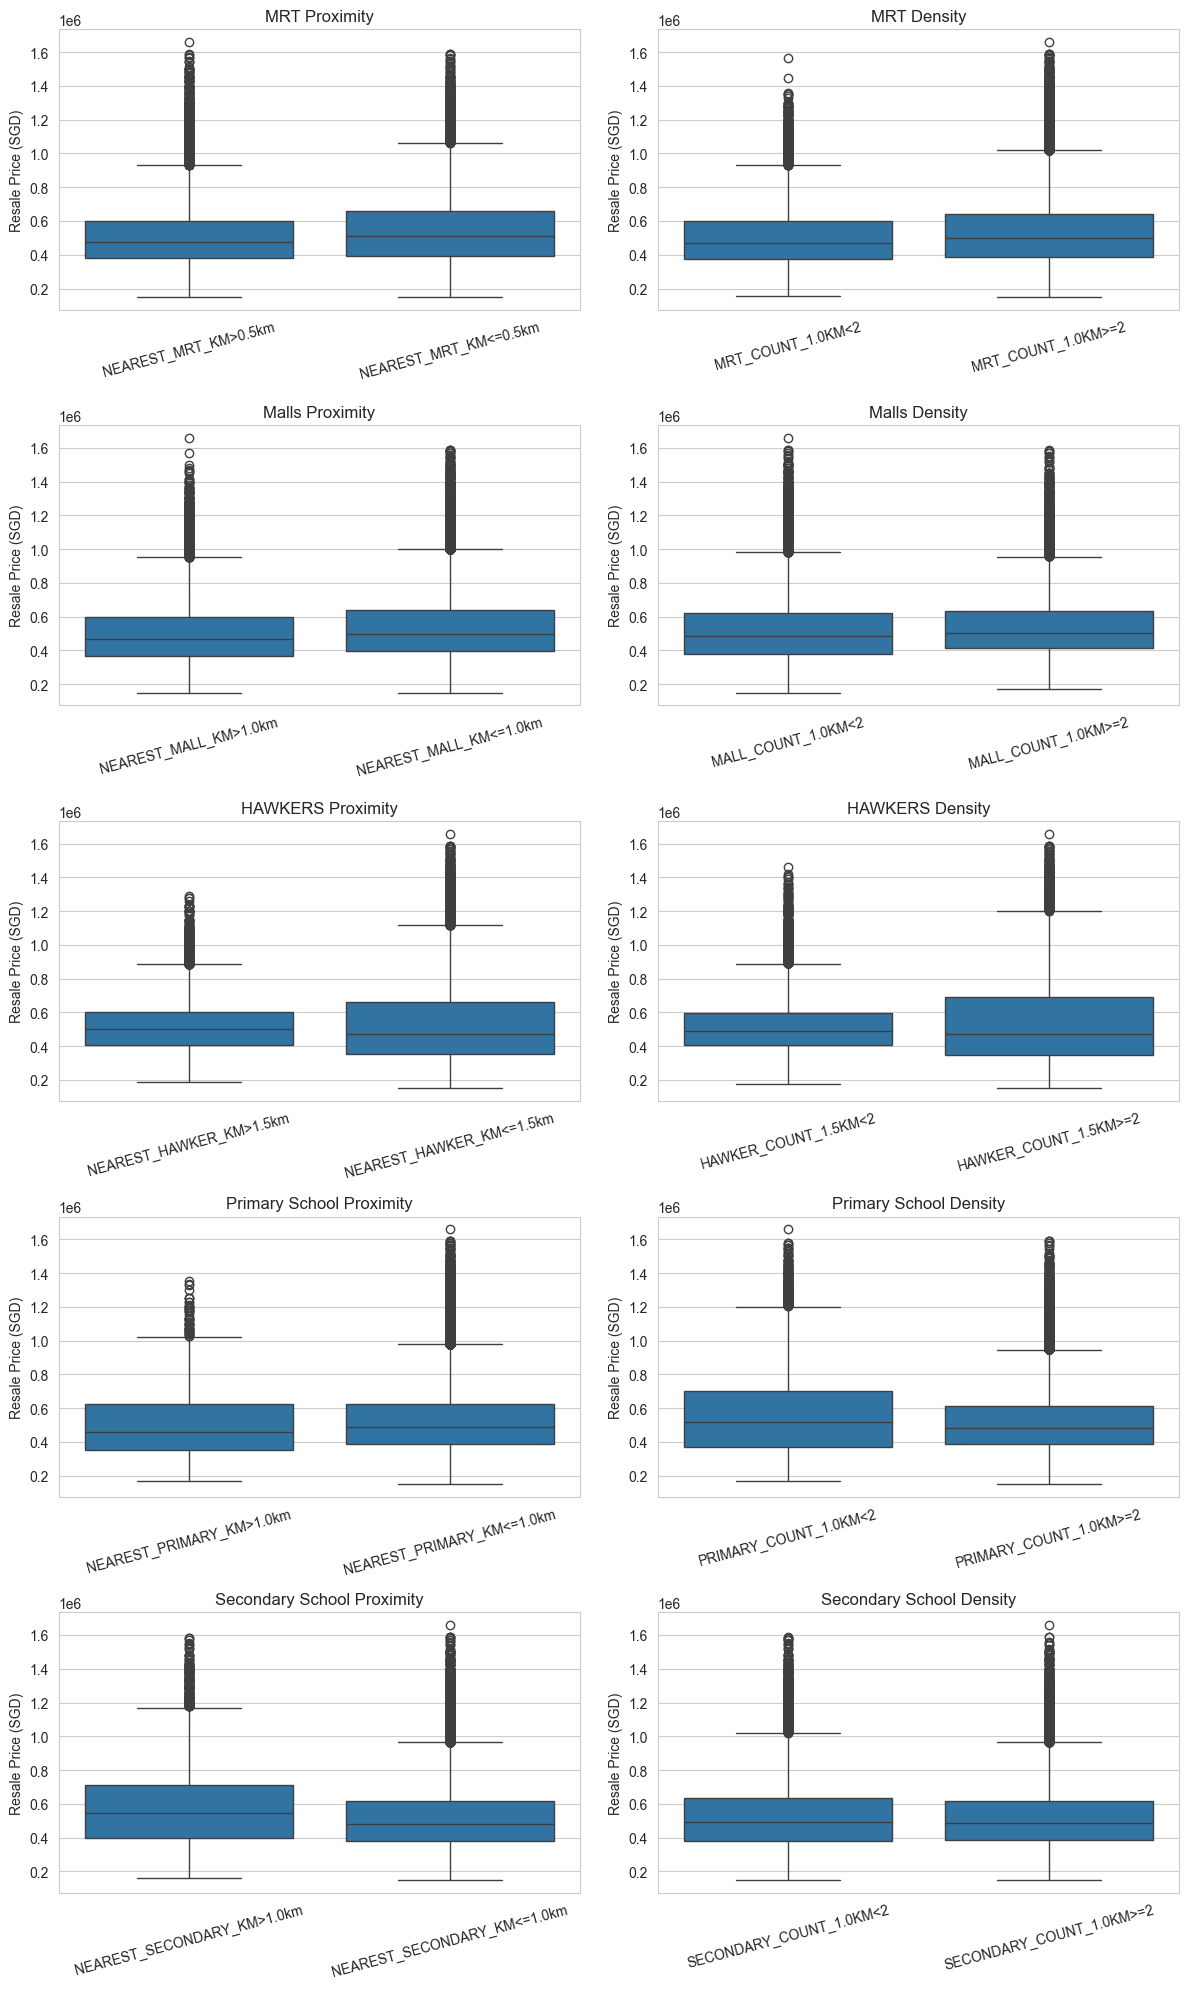

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(12, 20)) 

amenities = [
    {'name': 'MRT', 'proximity': 'NEAREST_MRT_KM', 'density': 'MRT_COUNT_1.0KM',
     'proximity_threshold': 0.5, 'density_threshold': 2, 'proximity_unit': 'km'},
    {'name': 'Malls', 'proximity': 'NEAREST_MALL_KM', 'density': 'MALL_COUNT_1.0KM',
     'proximity_threshold': 1.0, 'density_threshold': 2, 'proximity_unit': 'km'},
    {'name': 'HAWKERS', 'proximity': 'NEAREST_HAWKER_KM', 'density': 'HAWKER_COUNT_1.5KM',
     'proximity_threshold': 1.5, 'density_threshold': 2, 'proximity_unit': 'km'},
    {'name': 'Primary School', 'proximity': 'NEAREST_PRIMARY_KM', 'density': 'PRIMARY_COUNT_1.0KM',
     'proximity_threshold': 1.0, 'density_threshold': 2, 'proximity_unit': 'km'},
    {'name': 'Secondary School', 'proximity': 'NEAREST_SECONDARY_KM', 'density': 'SECONDARY_COUNT_1.0KM',
     'proximity_threshold': 1.0, 'density_threshold': 2, 'proximity_unit': 'km'},
]


for row_idx, amenity in enumerate(amenities):

    mask_proximity = sub[amenity['proximity']] <= amenity['proximity_threshold']
    label_far = f'{amenity["proximity"]}>{amenity["proximity_threshold"]}{amenity["proximity_unit"]}'
    label_close = f'{amenity["proximity"]}<={amenity["proximity_threshold"]}{amenity["proximity_unit"]}'

  
    sns.boxplot(ax=axes[row_idx, 0], data=sub.assign(group=np.where(mask_proximity, label_close, label_far)), x='group',
                y='RESALE_PRICE', order=[label_far, label_close])
    axes[row_idx, 0].set_title(f'{amenity["name"]} Proximity')
    axes[row_idx, 0].set_xlabel('')
    axes[row_idx, 0].set_ylabel('Resale Price (SGD)')
    axes[row_idx, 0].tick_params(axis='x', rotation=15)

    # --- 第 2 列: Density ---
    mask_density = sub[amenity['density']] >= amenity['density_threshold']
    label_high = f'{amenity["density"]}>={amenity["density_threshold"]}'
    label_low = f'{amenity["density"]}<{amenity["density_threshold"]}'


    sns.boxplot(ax=axes[row_idx, 1], data=sub.assign(group=np.where(mask_density, label_high, label_low)), x='group',
                y='RESALE_PRICE', order=[label_low, label_high])
    axes[row_idx, 1].set_title(f'{amenity["name"]} Density')
    axes[row_idx, 1].set_xlabel('')
    axes[row_idx, 1].set_ylabel('Resale Price (SGD)')
    axes[row_idx, 1].tick_params(axis='x', rotation=15)


plt.tight_layout()

# plt.savefig('../Plots/amenity_proximity_density_analysis_5x2.png', dpi=300, bbox_inches='tight')
plt.show()

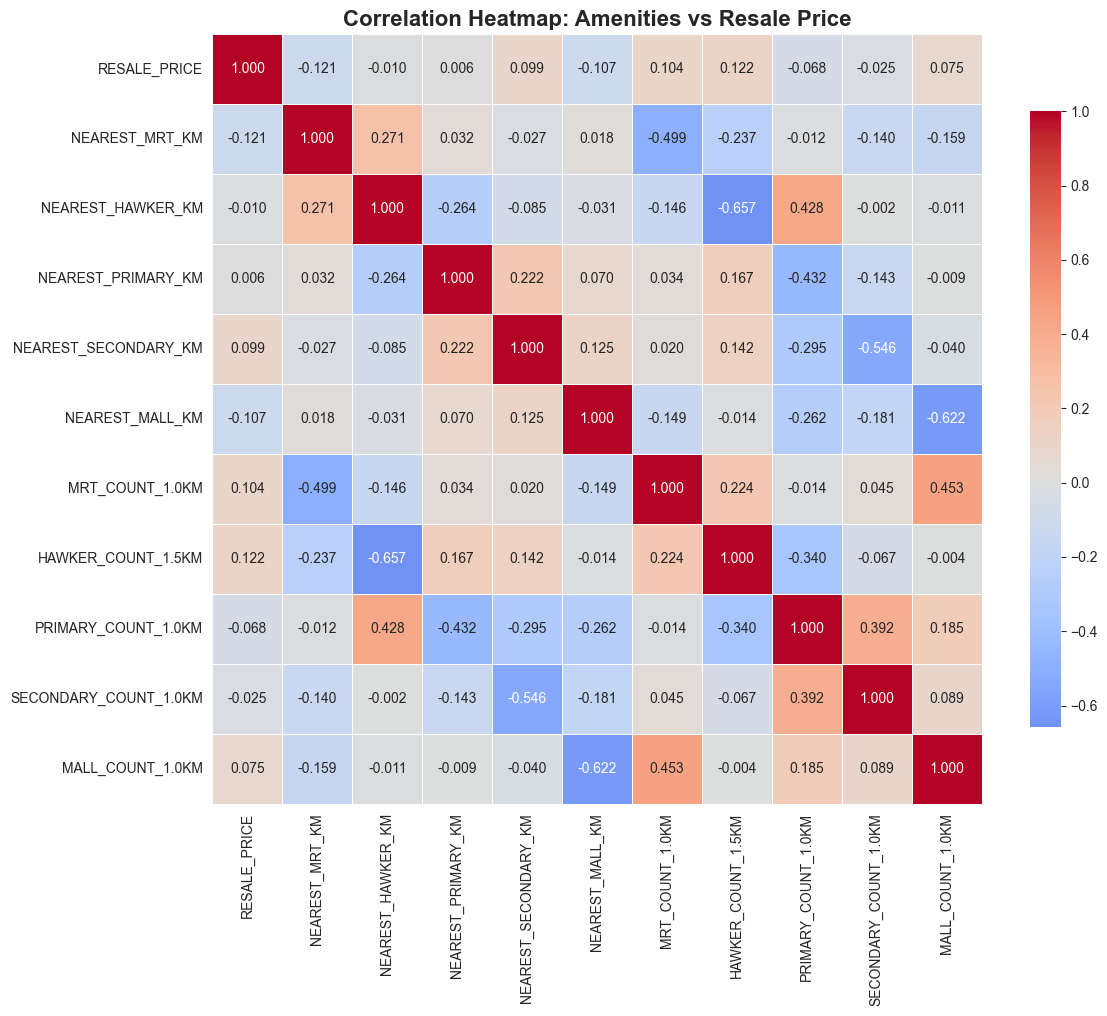

In [36]:
##Heatmap
distances = ['NEAREST_MRT_KM', 'NEAREST_HAWKER_KM', 
             'NEAREST_PRIMARY_KM', 'NEAREST_SECONDARY_KM','NEAREST_MALL_KM']
counts = ['MRT_COUNT_1.0KM', 'HAWKER_COUNT_1.5KM', 
          'PRIMARY_COUNT_1.0KM', 'SECONDARY_COUNT_1.0KM','MALL_COUNT_1.0KM']
amenity_features = distances + counts
correlation_matrix = df_processed_with_location[amenity_features + ['RESALE_PRICE']].corr()
if 'RESALE_PRICE' in correlation_matrix.columns:
    cols_reordered = ['RESALE_PRICE'] + [col for col in correlation_matrix.columns if col != 'RESALE_PRICE']
    correlation_matrix = correlation_matrix.loc[cols_reordered, cols_reordered]

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Heatmap: Amenities vs Resale Price', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [37]:
temp_cols=["REMAINING_AGE","RESALE_PRICE","NEAREST_HAWKER_KM","NEAREST_MRT_KM","NEAREST_PRIMARY_KM","NEAREST_MALL_KM","NEAREST_SECONDARY_KM"]
temp_df=df_processed_with_location[temp_cols].copy()
lease_median=temp_df['REMAINING_AGE'].median()
temp_df["LEASE_CATEGORY"]=np.where(temp_df["REMAINING_AGE"]>=lease_median,"new","old")
temp_df['HAWKER_PROXIMITY']=np.where(temp_df["NEAREST_HAWKER_KM"]<=1.0,"close","far(>1km)")
temp_df['MRT_PROXIMITY']=np.where(temp_df["NEAREST_MRT_KM"]<=1.0,"close","far(>1km)")
temp_df['PRIMARY_PROXIMITY']=np.where(temp_df["NEAREST_PRIMARY_KM"]<=1.0,"close","far(>1km)")
temp_df['MALL_PROXIMITY']=np.where(temp_df["NEAREST_MALL_KM"]<=1.0,"close","far(>1km)")
temp_df['SECONDARY_PROXIMITY']=np.where(temp_df["NEAREST_SECONDARY_KM"]<=1.0,"close","far(>1km)")
temp_analysis_age_and_secondary=temp_df.groupby(["LEASE_CATEGORY","SECONDARY_PROXIMITY"])['RESALE_PRICE'].median()
print('==REMAINING AGE AND SECONDARY SCHOOL PROXIMITY==')
print(temp_analysis_age_and_secondary)
temp_analysis_age_and_hawker=temp_df.groupby(["LEASE_CATEGORY","HAWKER_PROXIMITY"])['RESALE_PRICE'].median()
print('==REMAINING AGE AND HAWKER PROXIMITY==')
print(temp_analysis_age_and_hawker)
temp_analysis_age_and_mrt=temp_df.groupby(["LEASE_CATEGORY","MRT_PROXIMITY"])['RESALE_PRICE'].median()
print('==REMAINING AGE AND MRT PROXIMITY==')
print(temp_analysis_age_and_mrt)
temp_analysis_age_and_primary=temp_df.groupby(["LEASE_CATEGORY","PRIMARY_PROXIMITY"])['RESALE_PRICE'].median()
print('==REMAINING AGE AND PRIMARY SCHOOL PROXIMITY==')
print(temp_analysis_age_and_primary)
temp_analysis_age_and_mall=temp_df.groupby(["LEASE_CATEGORY","MALL_PROXIMITY"])['RESALE_PRICE'].median()
print('==REMAINING AGE AND MALL PROXIMITY==')
print(temp_analysis_age_and_mall)



==REMAINING AGE AND SECONDARY SCHOOL PROXIMITY==
LEASE_CATEGORY  SECONDARY_PROXIMITY
new             close                  525888.0
                far(>1km)              628888.0
old             close                  430000.0
                far(>1km)              438000.0
Name: RESALE_PRICE, dtype: float64
==REMAINING AGE AND HAWKER PROXIMITY==
LEASE_CATEGORY  HAWKER_PROXIMITY
new             close               715000.0
                far(>1km)           500000.0
old             close               400000.0
                far(>1km)           489000.0
Name: RESALE_PRICE, dtype: float64
==REMAINING AGE AND MRT PROXIMITY==
LEASE_CATEGORY  MRT_PROXIMITY
new             close            545000.0
                far(>1km)        490000.0
old             close            435000.0
                far(>1km)        380000.0
Name: RESALE_PRICE, dtype: float64
==REMAINING AGE AND PRIMARY SCHOOL PROXIMITY==
LEASE_CATEGORY  PRIMARY_PROXIMITY
new             close                530000.0
     

In [38]:
print('''\n Analysis Conclusions: Feature Correlation and Interaction Effects
1. Correlation Heatmap Analysis
Weak Linear Correlation: The Pearson Correlation Heatmap shows that the linear relationship between all amenity features (both distance _KM and count _COUNT) and RESALE_PRICE is very weak (absolute correlation coefficients are generally below 0.13).

Indication of Non-Linearity: This does not mean the amenities are unimportant. Instead, it strongly suggests that their relationship with resale price is non-linear. For example, there might be a "golden distance" for MRT stations (e.g., 200m-800m), where being too close (noise) or too far both result in lower prices.

Model Selection Justification: This finding strongly supports our hypothesis that we should use tree-based models like XGBoost (which excels at capturing non-linear patterns) over Linear Regression (which can only capture linear relationships).

2. Groupby Analysis - Uncovering Interaction Effects
To test the non-linearity hypothesis, we grouped the data by LEASE_CATEGORY (new/old) and PROXIMITY (close/far) to observe the median resale prices.

Interaction Effects Discovered: The analysis reveals that LEASE_CATEGORY (remaining lease) acts as a strong moderator that changes the effect of other amenities on price.

Reversal of Trends (Simpson's Paradox):

Hawker: For new leases, close (715k) is significantly more expensive than far (500k). For old leases, the trend reverses: close (400k) is significantly cheaper than far (489k).

Primary School: For new leases, close (530k) is cheaper than far (605k). For old leases, close (430k) is more expensive than far (380k).

Conclusion: This perfectly explains why the overall correlation in the heatmap was near zero. The positive and negative trends cancelled each other out when aggregated. This proves that our model must be able to capture these complex feature interactions, which XGBoost is designed to do.

Consistent Trends: Meanwhile, MRT and MALL proximity consistently show that close is more expensive than far for both new and old leases, aligning with general intuition.''')


 Analysis Conclusions: Feature Correlation and Interaction Effects
1. Correlation Heatmap Analysis
Weak Linear Correlation: The Pearson Correlation Heatmap shows that the linear relationship between all amenity features (both distance _KM and count _COUNT) and RESALE_PRICE is very weak (absolute correlation coefficients are generally below 0.13).

Indication of Non-Linearity: This does not mean the amenities are unimportant. Instead, it strongly suggests that their relationship with resale price is non-linear. For example, there might be a "golden distance" for MRT stations (e.g., 200m-800m), where being too close (noise) or too far both result in lower prices.

Model Selection Justification: This finding strongly supports our hypothesis that we should use tree-based models like XGBoost (which excels at capturing non-linear patterns) over Linear Regression (which can only capture linear relationships).

2. Groupby Analysis - Uncovering Interaction Effects
To test the non-linearity hyp

In [39]:
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
import time # for tracking progress

# --- 1. Prepare for KNN ---

df_KNN_Kfold = df_processed_with_location.copy() 

K_VALUES = [16, 32, 64, 128] 

N_SPLITS = 5 
# Prepare the coordinate data (X) and the target variable (y) for KNN

X_geo = df_KNN_Kfold[['LATITUDE', 'LONGITUDE']].values
y_price = df_KNN_Kfold['RESALE_PRICE'].values # Use the original price, not LOG_PRICE

print(f"Ready to generate KNN features in {len(df_KNN_Kfold)} rows data...")
print(f"K value list: {K_VALUES}")
print(f"K-Fold fold number: {N_SPLITS}")


# --- 2. Initialize K-Fold and new features columns ---

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for k in K_VALUES:
    df_KNN_Kfold[f'GEO_AVG_PRICE_K{k}'] = np.nan
    df_KNN_Kfold[f'GEO_STD_PRICE_K{k}'] = np.nan

# --- 3. Loop to generate features (core logic) ---

fold_counter = 1
start_time = time.time()

for train_idx, val_idx in kf.split(X_geo):
    
    print(f"\n--- Processing the {fold_counter}/{N_SPLITS} fold ---")
    
    # (A) Split the "training set" and "validation set"
    # "Training set" (train) is used to build the neighbor finder
    # "Validation set" (val) is the target for which we want to generate features
    X_train_fold, y_train_fold = X_geo[train_idx], y_price[train_idx]
    X_val_fold = X_geo[val_idx]

    # (B) Fit the KNN model on the "training set"
    # We only look for neighbors in X_train_fold
    print(f"Fitting KNN model (on {len(X_train_fold)} points)...")
    nn_model = NearestNeighbors(n_neighbors=max(K_VALUES), n_jobs=-1, metric='haversine')
    nn_model.fit(X_train_fold)
    
    # (C) Find the K nearest neighbors for the "validation set"
    # This will return the distances (distances) and the indices (indices) of the neighbors in X_train_fold
    print(f"Finding neighbors for {len(X_val_fold)} points...")
    distances, indices = nn_model.kneighbors(X_val_fold)

    # (D) 
    # We use 'indices' to extract the prices of the neighbors from 'y_train_fold' (the price of the training set)
    # This is safe because y_val_fold (the price of the validation set) is not involved
    
    for k in K_VALUES:
        # Select the first k neighbors from all neighbors
        k_indices = indices[:, :k] 
        # Find the real prices of the k neighbor
        neighbor_prices = y_train_fold[k_indices] 
        mean_features = np.mean(neighbor_prices, axis=1)
        std_features = np.std(neighbor_prices, axis=1)
        df_KNN_Kfold.loc[val_idx, f'GEO_AVG_PRICE_K{k}'] = mean_features
        df_KNN_Kfold.loc[val_idx, f'GEO_STD_PRICE_K{k}'] = std_features

    print(f"{fold_counter} fold processing completed.")
    fold_counter += 1

end_time = time.time()
print(f"\n--- All KNN features generated! Total time: {(end_time - start_time):.2f} seconds ---")


print("\n ====Save the training set geographic information====")

train_geo_info = {
    'coordinates': X_geo, 
    'prices': y_price,             
    'k_values': K_VALUES,           
    'n_samples': len(X_geo),       
}

# 
with open('../Dataset/train_geo_info.pkl', 'wb') as f:
    pickle.dump(train_geo_info, f)
print(f"Train geographic information saved to '../Dataset/train_geo_info.pkl'")

print("\n ====Save KNN feature statistics====")

knn_feature_stats = {}
knn_cols = [col for col in df_KNN_Kfold.columns if 'GEO_' in col]

for col in knn_cols:
    knn_feature_stats[col] = {
        'mean': df_KNN_Kfold[col].mean(),
        'median': df_KNN_Kfold[col].median(),
        'std': df_KNN_Kfold[col].std(),
        'min': df_KNN_Kfold[col].min(),
        'max': df_KNN_Kfold[col].max()
    }
    print(f"  {col}: mean={df_KNN_Kfold[col].mean():.2f}, median={df_KNN_Kfold[col].median():.2f}")

with open('../Dataset/knn_feature_stats.pkl', 'wb') as f:
    pickle.dump(knn_feature_stats, f)
print(f"\n KNN feature statistics saved to '../Dataset/knn_feature_stats.pkl'")
print(f"  Saved statistics for {len(knn_feature_stats)} KNN features")

Ready to generate KNN features in 162570 rows data...
K value list: [16, 32, 64, 128]
K-Fold fold number: 5

--- Processing the 1/5 fold ---
Fitting KNN model (on 130056 points)...
Finding neighbors for 32514 points...
1 fold processing completed.

--- Processing the 2/5 fold ---
Fitting KNN model (on 130056 points)...
Finding neighbors for 32514 points...
2 fold processing completed.

--- Processing the 3/5 fold ---
Fitting KNN model (on 130056 points)...
Finding neighbors for 32514 points...
3 fold processing completed.

--- Processing the 4/5 fold ---
Fitting KNN model (on 130056 points)...
Finding neighbors for 32514 points...
4 fold processing completed.

--- Processing the 5/5 fold ---
Fitting KNN model (on 130056 points)...
Finding neighbors for 32514 points...
5 fold processing completed.

--- All KNN features generated! Total time: 10.03 seconds ---

 ====Save the training set geographic information====
Train geographic information saved to '../Dataset/train_geo_info.pkl'

 ==


=== KNN feature engineering effect visualization ===



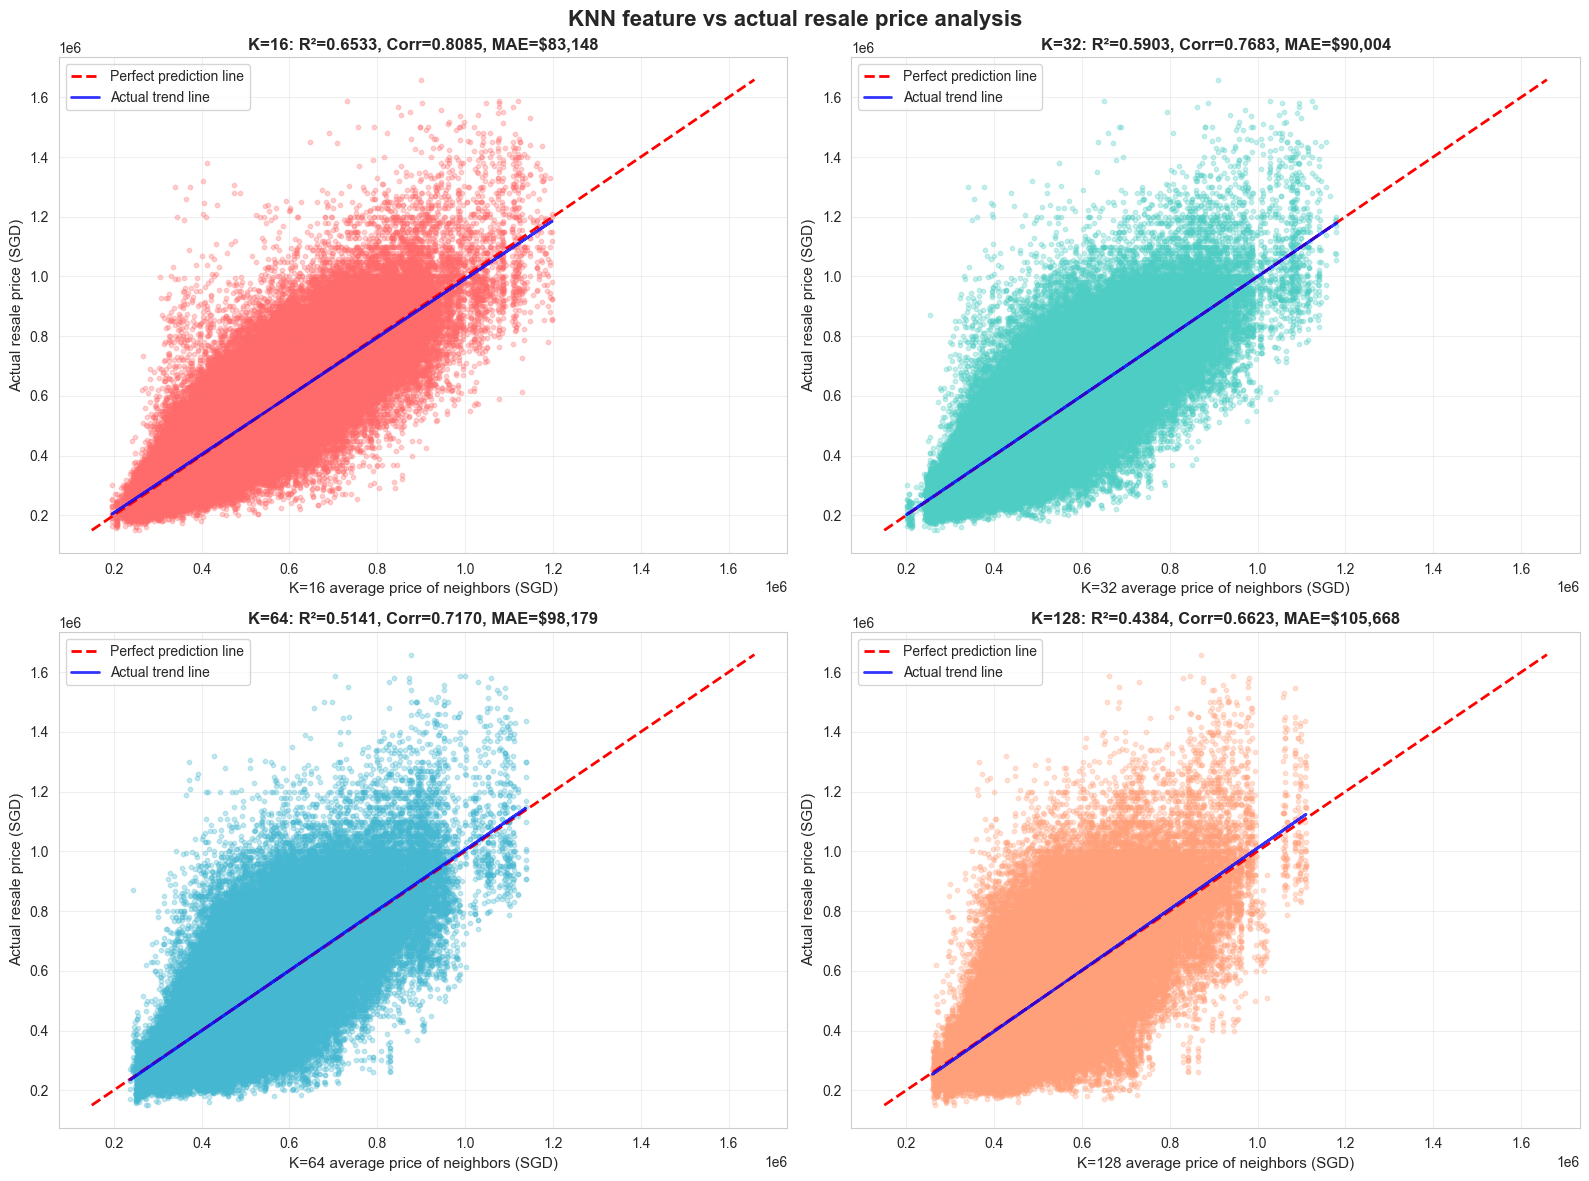

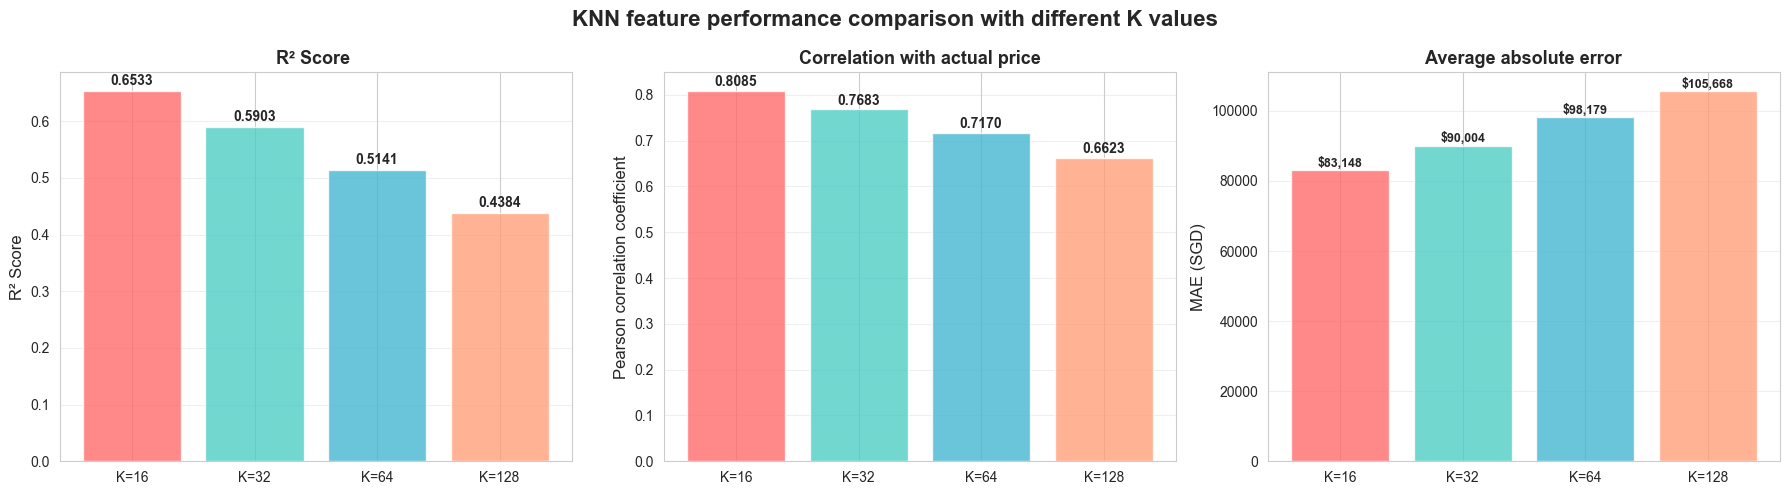

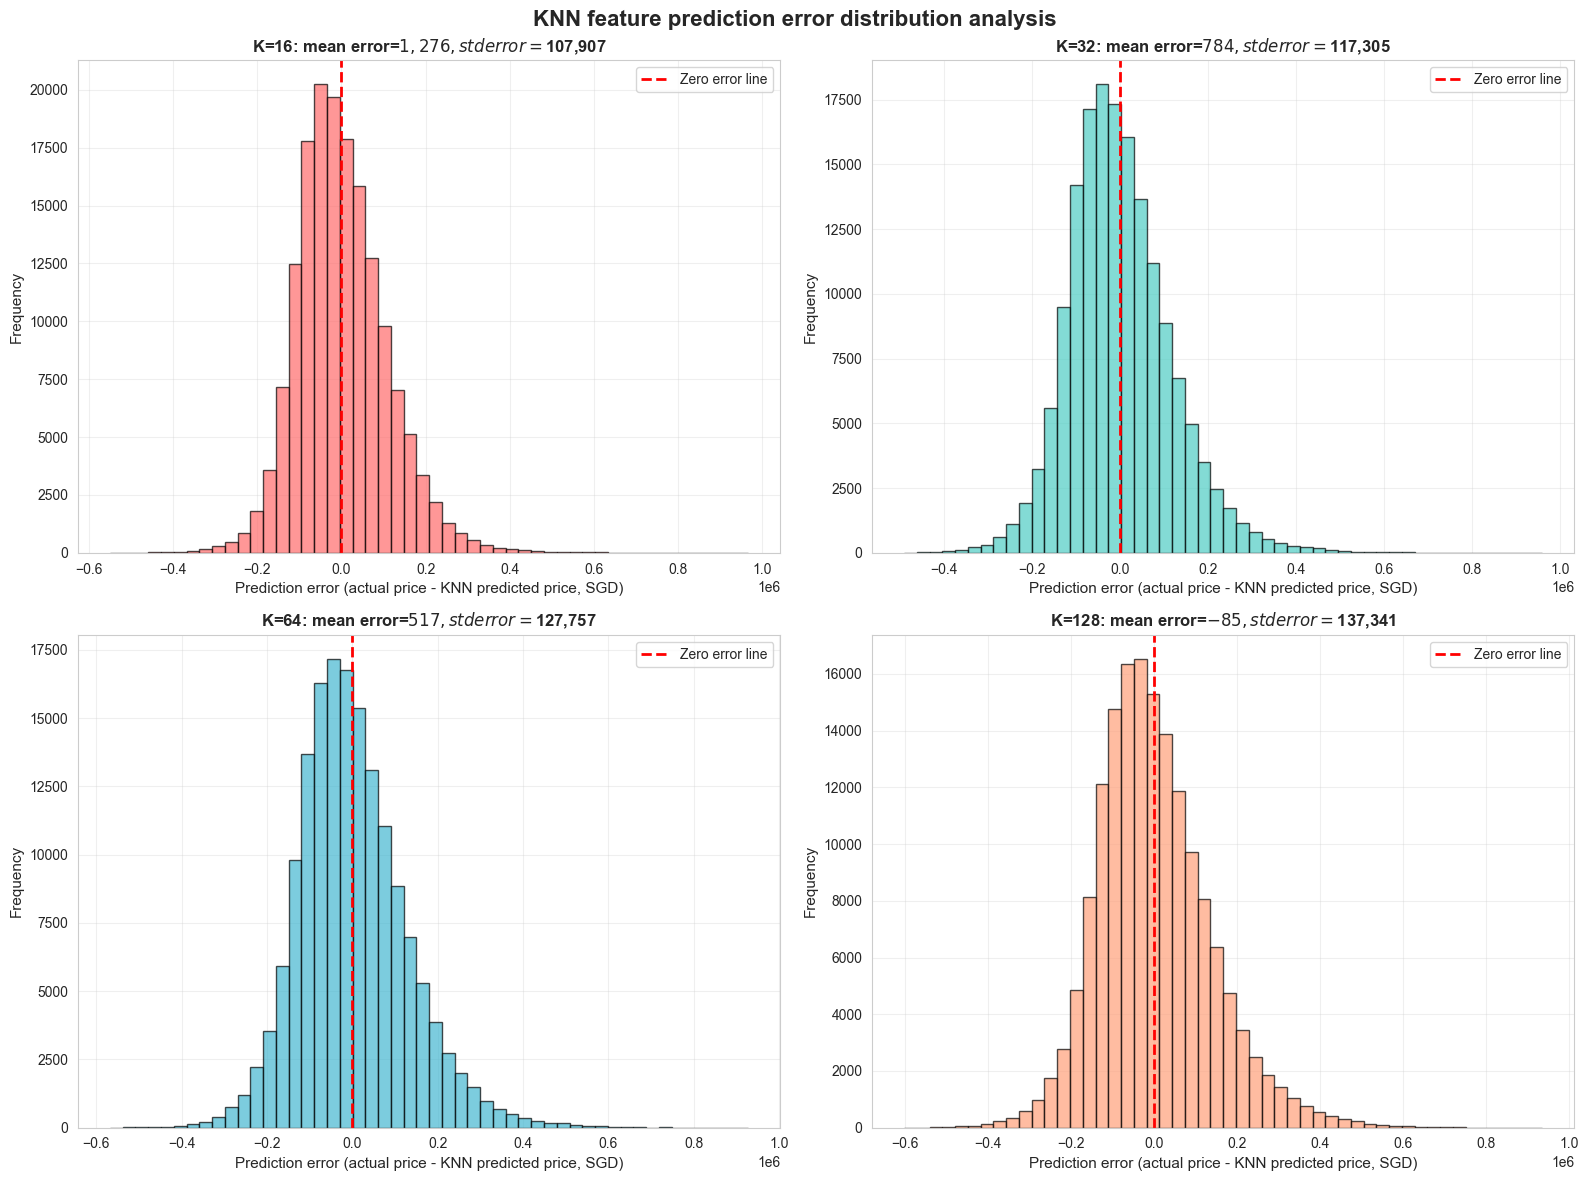

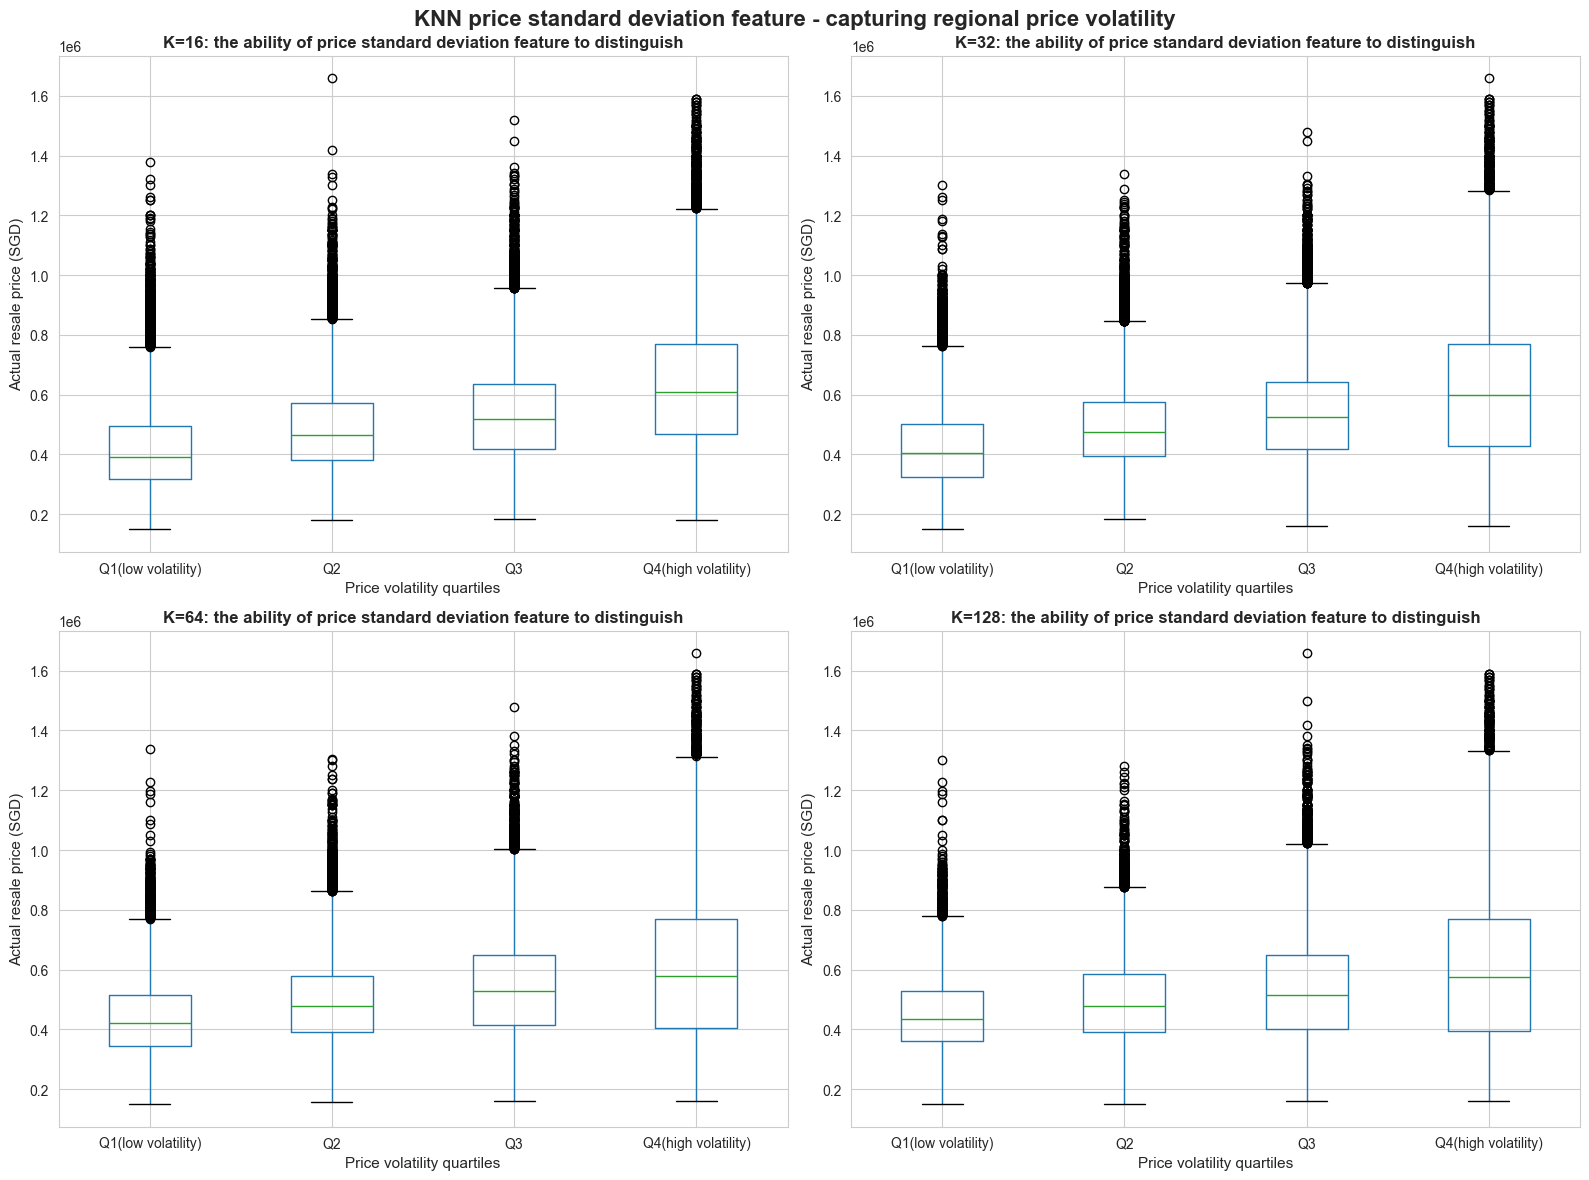

KNN feature engineering effect summary

  K value R² Score Correlation MAE (SGD) MAPE (%)
      16   0.6533      0.8085   $83,148   16.88%
      32   0.5903      0.7683   $90,004   18.52%
      64   0.5141      0.7170   $98,179   20.46%
     128   0.4384      0.6623  $105,668   22.23%


 All visualizations completed!

【Feature quality summary】
• Best K value recommendation: K=16 (R²=0.6533)
• Average correlation coefficient: 0.7390
• KNN features can explain 65.33% of the price variance
• This proves that location features are very important for price prediction!


In [40]:
from sklearn.metrics import r2_score, mean_absolute_error
print("\n=== KNN feature engineering effect visualization ===\n")

# 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('KNN feature vs actual resale price analysis', fontsize=16, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
k_values_with_colors = list(zip(K_VALUES, colors))

for idx, (k, color) in enumerate(k_values_with_colors):
    row = idx // 2
    col = idx % 2
    
    
    x = df_KNN_Kfold[f'GEO_AVG_PRICE_K{k}']
    y = df_KNN_Kfold['RESALE_PRICE']
    

    r2 = r2_score(y, x)
    mae = mean_absolute_error(y, x)
    corr = np.corrcoef(x, y)[0, 1]
    
  
    axes[row, col].scatter(x, y, alpha=0.3, s=10, color=color)
    

    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    axes[row, col].plot([min_val, max_val], [min_val, max_val], 
                        'r--', linewidth=2, label='Perfect prediction line')
    

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axes[row, col].plot(x, p(x), "b-", alpha=0.8, linewidth=2, label='Actual trend line')
    
    axes[row, col].set_xlabel(f'K={k} average price of neighbors (SGD)', fontsize=11)
    axes[row, col].set_ylabel('Actual resale price (SGD)', fontsize=11)
    axes[row, col].set_title(f'K={k}: R²={r2:.4f}, Corr={corr:.4f}, MAE=${mae:,.0f}', 
                             fontsize=12, fontweight='bold')
    axes[row, col].legend(loc='upper left')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('../Plots/knn_feature_quality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# print("figure 1 has been saved: knn_feature_quality_analysis.png")



fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('KNN feature performance comparison with different K values', fontsize=16, fontweight='bold')

metrics = {'R²': [], 'Correlation': [], 'MAE': []}

for k in K_VALUES:
    x = df_KNN_Kfold[f'GEO_AVG_PRICE_K{k}']
    y = df_KNN_Kfold['RESALE_PRICE']
    
    metrics['R²'].append(r2_score(y, x))
    metrics['Correlation'].append(np.corrcoef(x, y)[0, 1])
    metrics['MAE'].append(mean_absolute_error(y, x))


axes[0].bar(range(len(K_VALUES)), metrics['R²'], color=colors, alpha=0.8)
axes[0].set_xticks(range(len(K_VALUES)))
axes[0].set_xticklabels([f'K={k}' for k in K_VALUES])
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score ', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(metrics['R²']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')


axes[1].bar(range(len(K_VALUES)), metrics['Correlation'], color=colors, alpha=0.8)
axes[1].set_xticks(range(len(K_VALUES)))
axes[1].set_xticklabels([f'K={k}' for k in K_VALUES])
axes[1].set_ylabel('Pearson correlation coefficient', fontsize=12)
axes[1].set_title('Correlation with actual price', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(metrics['Correlation']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')


axes[2].bar(range(len(K_VALUES)), metrics['MAE'], color=colors, alpha=0.8)
axes[2].set_xticks(range(len(K_VALUES)))
axes[2].set_xticklabels([f'K={k}' for k in K_VALUES])
axes[2].set_ylabel('MAE (SGD)', fontsize=12)
axes[2].set_title('Average absolute error', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(metrics['MAE']):
    axes[2].text(i, v + 1000, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
# plt.savefig('../Plots/knn_k_values_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# print("figure 2 has been saved: knn_k_values_comparison.png")



fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('KNN feature prediction error distribution analysis', fontsize=16, fontweight='bold')

for idx, (k, color) in enumerate(k_values_with_colors):
    row = idx // 2
    col = idx % 2
    
    x = df_KNN_Kfold[f'GEO_AVG_PRICE_K{k}']
    y = df_KNN_Kfold['RESALE_PRICE']
    errors = y - x
    
   
    axes[row, col].hist(errors, bins=50, alpha=0.7, color=color, edgecolor='black')
    axes[row, col].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error line')
    axes[row, col].set_xlabel('Prediction error (actual price - KNN predicted price, SGD)', fontsize=11)
    axes[row, col].set_ylabel('Frequency', fontsize=11)
    

    mean_error = errors.mean()
    std_error = errors.std()
    
    axes[row, col].set_title(
        f'K={k}: mean error=${mean_error:,.0f}, std error=${std_error:,.0f}',
        fontsize=12, fontweight='bold'
    )
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('../Plots/knn_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# print("✓ Figure 3 has been saved: knn_error_distribution.png")



fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('KNN price standard deviation feature - capturing regional price volatility', fontsize=16, fontweight='bold')

for idx, (k, color) in enumerate(k_values_with_colors):
    row = idx // 2
    col = idx % 2
    
    
    std_col = f'GEO_STD_PRICE_K{k}'
    
    
    df_temp = df_KNN_Kfold.copy()
    df_temp['STD_QUARTILE'] = pd.qcut(df_temp[std_col], q=4, 
                                   labels=['Q1(low volatility)', 'Q2', 'Q3', 'Q4(high volatility)'])
    df_temp.boxplot(column='RESALE_PRICE', by='STD_QUARTILE', ax=axes[row, col])

    
    axes[row, col].set_xlabel('Price volatility quartiles', fontsize=11)
    axes[row, col].set_ylabel('Actual resale price (SGD)', fontsize=11)
    axes[row, col].set_title(f'K={k}: the ability of price standard deviation feature to distinguish', fontsize=12, fontweight='bold')
    axes[row, col].get_figure().suptitle('') 

plt.suptitle('KNN price standard deviation feature - capturing regional price volatility', fontsize=16, fontweight='bold')
plt.tight_layout()
# plt.savefig('../Plots/knn_std_feature_effectiveness.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Figure 4 has been saved: knn_std_feature_effectiveness.png")



print("KNN feature engineering effect summary")
print("="*60)

summary_data = []
for k in K_VALUES:
    x = df_KNN_Kfold[f'GEO_AVG_PRICE_K{k}']
    y = df_KNN_Kfold['RESALE_PRICE']
    
    r2 = r2_score(y, x)
    corr = np.corrcoef(x, y)[0, 1]
    mae = mean_absolute_error(y, x)
    mape = np.mean(np.abs((y - x) / y)) * 100
    
    summary_data.append({
        'K value': k,
        'R² Score': f'{r2:.4f}',
        'Correlation': f'{corr:.4f}',
        'MAE (SGD)': f'${mae:,.0f}',
        'MAPE (%)': f'{mape:.2f}%'
    })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))
print("\n" + "="*60)

print("\n All visualizations completed!")
print("\n【Feature quality summary】")
print(f"• Best K value recommendation: K={K_VALUES[np.argmax(metrics['R²'])]} (R²={max(metrics['R²']):.4f})")
print(f"• Average correlation coefficient: {np.mean(metrics['Correlation']):.4f}")
print(f"• KNN features can explain {max(metrics['R²'])*100:.2f}% of the price variance")
print(f"• This proves that location features are very important for price prediction!")

In [41]:
df_KNN_Kfold[['TOWN','RESALE_PRICE','GEO_AVG_PRICE_K16','GEO_STD_PRICE_K16','GEO_AVG_PRICE_K32','GEO_STD_PRICE_K32','GEO_AVG_PRICE_K64','GEO_STD_PRICE_K64','GEO_AVG_PRICE_K128','GEO_STD_PRICE_K128']].head(10)

,TOWN,RESALE_PRICE,GEO_AVG_PRICE_K16,GEO_STD_PRICE_K16,GEO_AVG_PRICE_K32,GEO_STD_PRICE_K32,GEO_AVG_PRICE_K64,GEO_STD_PRICE_K64,GEO_AVG_PRICE_K128,GEO_STD_PRICE_K128
0,woodlands,420000.0,572062.500,145032.095047,544315.25000,129587.824889,558246.125000,105665.451456,575269.000000,109565.071440
1,bishan,585000.0,662062.500,171308.737646,646715.25000,147346.009649,739850.625000,221017.703572,690989.781250,181830.341028
2,bukit panjang,450000.0,490243.000,96099.348255,535986.06250,122967.201151,514520.218750,131589.702334,488715.812500,124594.710725
3,punggol,465000.0,532886.750,90248.626491,508811.34375,90044.766074,492409.984375,90319.142761,468786.835938,85118.785237
4,hougang,710000.0,693430.500,92522.461888,694215.25000,78151.735806,656086.562500,70845.717712,637937.343750,101410.798154
5,clementi,590000.0,421136.125,152175.009283,427411.81250,167574.187752,399560.031250,153704.656153,408798.390625,127893.598011
6,bukit panjang,328000.0,342399.250,30717.153326,372449.62500,66824.746852,403238.687500,85646.856052,446950.906250,115818.915678
7,bedok,488000.0,348562.500,67582.328265,422062.50000,97246.766495,454404.484375,131975.914094,502283.398438,165773.097533
8,punggol,628888.0,490909.500,106197.624483,488237.62500,93807.002579,487302.812500,93422.927704,488242.273438,94323.031077
9,yishun,480000.0,437437.500,100260.266775,515048.50000,120638.614116,511442.609375,123618.544919,468983.617188,125345.544833


### Final normalization on newly generated features

In [42]:
all_features=df_KNN_Kfold.columns.to_list()
print(f"The number of all features: {len(all_features)}")
print(f"The total features are: {all_features}")


The number of all features: 117
The total features are: ['MONTH', 'TOWN', 'FLAT_TYPE', 'BLOCK', 'STREET', 'FLOOR_RANGE', 'FLOOR_AREA_SQM', 'FLAT_MODEL', 'ECO_CATEGORY', 'LEASE_COMMENCE_DATA', 'RESALE_PRICE', 'LOG_RESALE_PRICE', 'YEAR', 'MONTH_NUM', 'TRANSACTION_YEAR', 'TRANSACTION_MONTH', 'REMAINING_AGE', 'FLOOR_LEVEL_LOW', 'FLOOR_LEVEL_HIGH', 'FLOOR_LEVEL_MID', 'PRICE_PER_SQM', 'FLAT_TYPE_CATEGORY', 'TOWN_CATEGORY', 'FLAT_TYPE_ENCODED', 'FLAT_MODEL_2 room', 'FLAT_MODEL_3gen', 'FLAT_MODEL_adjoined flat', 'FLAT_MODEL_apartment', 'FLAT_MODEL_dbss', 'FLAT_MODEL_improved', 'FLAT_MODEL_improved maisonette', 'FLAT_MODEL_maisonette', 'FLAT_MODEL_model a', 'FLAT_MODEL_model a maisonette', 'FLAT_MODEL_model a2', 'FLAT_MODEL_multi generation', 'FLAT_MODEL_new generation', 'FLAT_MODEL_premium apartment', 'FLAT_MODEL_premium apartment loft', 'FLAT_MODEL_premium maisonette', 'FLAT_MODEL_simplified', 'FLAT_MODEL_standard', 'FLAT_MODEL_terrace', 'FLAT_MODEL_type s1', 'FLAT_MODEL_type s2', 'TOWN_ang m

In [43]:

eda_columns_to_drop = [
    'FLOOR_AREA_SQM_SCALED',
    'LEASE_COMMENCE_DATA_SCALED',
    'REMAINING_AGE_SCALED',
    'FLOOR_LEVEL_MID_SCALED',
    'TRANSACTION_YEAR_SCALED',
    'FLOOR_AREA_SQM_NORM',
    'LEASE_COMMENCE_DATA_NORM',
    'REMAINING_AGE_NORM',
    'FLOOR_LEVEL_MID_NORM',
    'TRANSACTION_YEAR_NORM'
]
#After feature engineering, some original columns are not necessary now
unnecessary_columns = [
    'FLAT_TYPE',
    'LEASE_COMMENCE_DATA', #since we have REMAINING_AGE and TRANSACTION_YEAR 
    'FLAT_MODEL',
    'FLOOR_LEVEL_CATEGORY',
    'FLOOR_RANGE',
    'FLOOR_LEVEL_LOW',
    'FLOOR_LEVEL_HIGH',
    'PRICE_PER_SQM',
    'TOWN_CATEGORY',
    'MONTH',
    'TOWN',
    'BLOCK',
    'STREET',
    'FLOOR_RANGE',
    'ECO_CATEGORY',
    'YEAR',
    'MONTH_NUM',
    'FLAT_TYPE_CATEGORY',
    'POSTAL_CODE',
]
print("Cleaning the normalized columns in EDA...")
print(f"Original column number: {df_KNN_Kfold.shape[1]}")
df_KNN_Kfold.drop(columns=eda_columns_to_drop, errors='ignore',inplace=True)
print(f"After cleaning, the column number is: {df_KNN_Kfold.shape[1]}")

print("Cleaning the unnecessary columns...")
print(f"Original column number: {df_KNN_Kfold.shape[1]}")
df_KNN_Kfold.drop(columns=unnecessary_columns, errors='ignore',inplace=True)
print(f"After cleaning, the column number is: {df_KNN_Kfold.shape[1]}")

df_KNN_Kfold.to_csv('../Dataset/train_data_for_modeling(no_standardization).csv',index=False)
print("Saved original features (no standardization applied)")


Cleaning the normalized columns in EDA...
Original column number: 117
After cleaning, the column number is: 107
Cleaning the unnecessary columns...
Original column number: 107
After cleaning, the column number is: 89
Saved original features (no standardization applied)


In [44]:
numerical_features_to_normalize = [
#basic features  
'FLOOR_AREA_SQM',  
'REMAINING_AGE',
'TRANSACTION_YEAR',
'TRANSACTION_MONTH',
'FLOOR_LEVEL_MID',
'MAX_FLOOR',
'LONGITUDE',
'LATITUDE',

#knn features
'GEO_AVG_PRICE_K16',
'GEO_STD_PRICE_K16',
'GEO_AVG_PRICE_K32',
'GEO_STD_PRICE_K32',
'GEO_AVG_PRICE_K64',
'GEO_STD_PRICE_K64',
'GEO_AVG_PRICE_K128',
'GEO_STD_PRICE_K128',
# amenities proximity and densityfeatures
'NEAREST_MRT_KM',
 'MRT_COUNT_0.5KM',
 'MRT_COUNT_1.0KM',
 'MRT_COUNT_2.0KM',
 'NEAREST_HAWKER_KM',
 'HAWKER_COUNT_0.5KM',
 'HAWKER_COUNT_1.5KM',
 'HAWKER_COUNT_3.0KM',
 'NEAREST_PRIMARY_KM',
 'PRIMARY_COUNT_1.0KM',
 'PRIMARY_COUNT_2.0KM',
 'PRIMARY_COUNT_3.0KM',
 'NEAREST_SECONDARY_KM',
 'SECONDARY_COUNT_1.0KM',
 'SECONDARY_COUNT_2.0KM',
 'SECONDARY_COUNT_3.0KM',
 'NEAREST_MALL_KM',
 'MALL_COUNT_1.0KM',
 'MALL_COUNT_2.0KM',
 'MALL_COUNT_3.0KM'] 

 #LONGITUDE, LATITUDE needed to be additionally normalized when using linear regression model
 # LOG_RESALE_PRICE needed to be used when using linear regression model
 # RESALE can be directly used when using Tree model

print(f'will normalize {len(numerical_features_to_normalize)} columns')

scaler = StandardScaler()
scaler.fit_transform(df_KNN_Kfold[numerical_features_to_normalize])
print("Standardization completed!")
all_final_features=df_KNN_Kfold.columns.to_list()

with open('../Dataset/features_standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open("../Dataset/numerical_features.json",'w') as f:
    json.dump(numerical_features_to_normalize,f)
with open("../Dataset/all_final_features.json",'w') as f:
    json.dump(all_final_features,f)
print(f"Standard scaler, numerical features and all features saved to '../Dataset/'")


will normalize 36 columns
Standardization completed!
Standard scaler, numerical features and all features saved to '../Dataset/'


In [45]:
len(all_final_features)

89

In [46]:
# # 4. Feature Selection - Keep Only Specified Columns
# print("\n4. Feature Selection")
# print("Selecting only the specified columns for analysis...")

# # Define the columns to keep
# columns_to_keep = [
#     'RESALE_PRICE',
#     'FLOOR_AREA_SQM', 
#     'REMAINING_AGE',
#     'TRANSACTION_YEAR',
#     'FLOOR_LEVEL_MID',
#     'FLAT_TYPE_ENCODED',
#     'FLAT_MODEL_ENCODED',
#     'TOWN',
#     'BLOCK', 
#     'STREET'
# ]

# # Check which columns exist in the dataset
# existing_columns = [col for col in columns_to_keep if col in df_processed.columns]
# missing_columns = [col for col in columns_to_keep if col not in df_processed.columns]

# print(f"Columns found in dataset: {existing_columns}")
# if missing_columns:
#     print(f"Columns not found in dataset: {missing_columns}")

# print(f"\nOriginal dataset shape: {df_processed.shape}")

# # Apply filtering directly to df_processed
# df_processed = df_processed[existing_columns]

# print(f"Filtered dataset shape: {df_processed.shape}")
# print(f"Columns retained: {len(existing_columns)}")

# print("\nFiltered Dataset Info:")
# print(df_processed.info())

# print("\nFirst 5 rows of filtered dataset:")
# print(df_processed.head())

